# Implementación de una red AC-GAN con Keras<a id="top"></a>

<i><small>Autor: Algigantix<br>Última actualización: 2023-04-28</small></i></div>

## Introducción

Las redes generativas adversariales (GAN, de _Generative Adversarial Networks_) fueron presentadas por primera vez por Goodfellow et al. en el artículo [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) publicado en 2014. Este tipo de redes pueden ser utilizadas para la generación sintética de datos prácticamente idénticos a los originales.

Para la generación de estos datos se usan dos redes neuronales durante el entrenamiento: la **generadora**, que acepta un vector de entrada de ruido generado aleatoriamente y produce los datos de salida de aspecto similar a los datos auténticos, y la **discriminadora**, que intenta determinar si los datos que se le presentan son auténticos o generados.

Entrenando estas redes al mismo tiempo, una retroalimentando a la otra, dispondremos de un medio para generar datos prácticamente indistinguibles de los originales, o visto de otro modo, dispondremos de un medio para determinar si unos determinados datos son verdaderos o _fake_.

Una AC-GAN (_Auxiliary Classifier GAN_) es una variante en la que se incluye la clasificación por clases en la entrada de las dos redes, y la red discriminadora puede clasificar según probabilidad de que una imagen sea de una clase u  otra. Además emplean redes de convolución.

En nuestro caso, diseñaremos una red ACGAN que trate de replicar caracteres escritos, basada en los resultados de [este artículo](https://arxiv.org/pdf/1610.09585.pdf) y esta [página web](https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/).

## Imports y configuración

Primero importamos las bibliotecas que necesitamos:
* emnist: la base de datos con números y letras
* enum: por definir las clases como una enumeración.
* tensorflow y keras: para lo relacionado con Redes de Neuronas (capas, optimizadores, algunos gráficos, modelos y guardar y cargar modelos).
* math: algunas funciones matemáticas.
* matplotlib.pyplot: elementos gráficos.
* numpy algunas operaciones sobre matrices, incluidas matrices aleatorias para el ruido.

Para facilitarnos la vida hemos decidido importar las capas directamente para no añadir un montón de texto.

In [77]:
#import collections # sería por el deque

from emnist import extract_training_samples
from emnist import extract_test_samples

import enum

import tensorflow as tf

from keras.initializers import RandomNormal

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Reshape

from keras.models import Model
from keras.models import load_model

from keras.optimizers import Adam

from keras.utils.vis_utils import plot_model

from math import sqrt

import matplotlib.pyplot as plt

#import numpy as np
from numpy import asarray
from numpy import ones
from numpy import zeros
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

También incluimos un pip por si faltan algunos paquetes en la instalación

In [12]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
!pip install emnist

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/77.1 kB ? eta -:--:--
     ---------------------------------------- 77.1/77.1 kB 4.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Asimismo algunas configuraciones gráficas.

In [4]:
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

## El dataset que usaremos

Utilizaremos un dataset de [emnist](https://pypi.org/project/emnist/), que tiene más datos que el de mnist. En este caso y por recomendación del profesor el dataset "balanced", que tiene 47 clases de caracteres.

Como se dice en [este estudio](https://arxiv.org/pdf/1610.09585.pdf), una mayor resolución ayuda en la discriminación,  pero para este caso 28x28 es más que suficiente.

In [121]:
WIDTH, HEIGHT, CHANNELS = 28, 28, 1

Train (112800, 28, 28) (112800,)
Test (18800, 28, 28) (18800,)


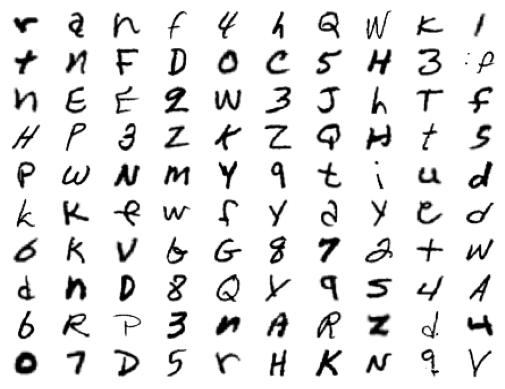

LINE 
45 36 43 15 4 42 26 32 20 1 LINE 
46 43 15 13 24 12 5 17 3 40 LINE 
42 14 14 44 32 3 19 42 29 40 LINE 
17 25 3 35 20 35 26 17 46 28 LINE 
25 32 23 22 34 9 46 19 30 38 LINE 
20 20 15 32 40 34 36 34 39 38 LINE 
37 20 31 16 16 44 7 2 46 32 LINE 
38 43 13 8 26 34 44 28 4 10 LINE 
6 27 25 3 43 10 27 35 38 4 LINE 
24 7 13 5 45 17 20 23 44 31 

In [81]:
# Cargamos las imágenes en la memoria

(trainX, trainy) = extract_training_samples('balanced')
(testX, testy) = extract_test_samples('balanced')

#(trainX, trainy), (testX, testy) = tf.keras.datasets.mnist.load_data()#load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

# Pintamos algunas imágenes para ver que se han cargado
for i in range(100):
 # define subplot
 plt.subplot(10, 10, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(trainX[i], cmap='gray_r')
plt.show()
for i in range(100):
    if i%10 == 0:
        print("LINE ")
    print(trainy[i], end= " ")


In [114]:
# Nos aseguramos que el máximo es el que dice ser
def masAlto(trainy):
    max = -1
    for i in range(len(trainy)):
        if trainy[i] > max:
            max = trainy[i]
    print(max)
    
masAlto(trainy)

46


In [90]:
# Una función auxiliar, que hemos utilizado para buscar letras y asegurarnos de que son lo que dicen ser
def buscar(trainy, buscado):
    enc = 0
    for i in range(len(trainy)):
        if trainy[i] == buscado:
            plt.imshow(trainX[i], cmap='gray_r')
            plt.show()
            enc+=1
            if enc == 2:
                return 0

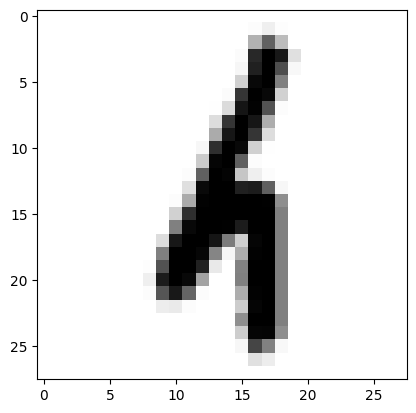

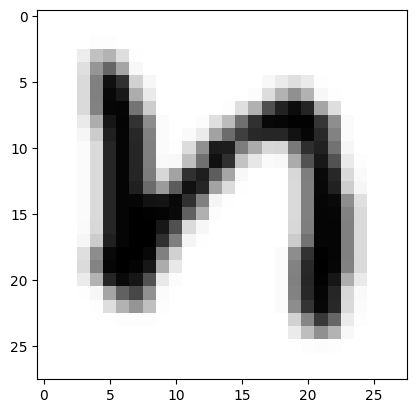

0

In [100]:
buscar(trainy, 42)

También definiremos las clases de letras y números, por claridad. Nótese que algunos caracteres están repetidos puesto que la base de datos los considera demasiado difíciles de distinguir.

In [148]:
class LosCaracteres(enum.Enum):
    """Cada una de los posibles caracteres."""
    el0 = 0
    el1 = 1
    el2 = 2
    el3 = 3
    el4 = 4
    el5 = 5
    el6 =  6
    el7 = 7
    el8 = 8
    el9 = 9
    elA = 10
    elB = 11
    elC = 12
    elD = 13
    elE = 14
    elF = 15
    elG = 16
    elH = 17
    elI = 18
    elJ = 19
    elK = 20
    elL = 21
    elM = 22
    elN = 23
    elO = 24
    elP = 25
    elQ = 26
    elR = 27
    elS = 28
    elT = 29
    elU = 30
    elV = 31
    elW = 32
    elX = 33
    elY = 34
    elZ = 35
    ela = 36
    elb = 37
    elc = 12
    eld = 38
    ele = 39
    elf = 40
    elg = 41
    elh = 42
    eli = 18
    elj = 19
    elk = 20
    ell = 21
    elm = 22
    eln = 43
    elo = 24
    elp = 25
    elq = 44
    elr = 45
    els = 28
    elt = 46
    elu = 30
    elv = 31
    elw = 32
    elx = 33
    ely = 34
    elz = 35


In [102]:
num_clases = 47

## Red generadora

La parte generadora de un modelo ACGAN se encarga de generar datos nuevos a partir de ruido aleatorio y una clase. Es de esperar que, a la larga, sea capaz de generar nuevos datos con una distribución similar a la de los elementos reales.

Y ya que hemos dicho _ruido aleatorio_, vamos con la definición de la longitud del vector de valores de entrada de ruido. Se puede hacer como hace el profesor, o bien definirla como una dimensión latente. Nosotros elegimos 100 por pura conveniencia.

In [106]:
# define the size of the latent space
latent_dim = 100

Por otra parte la clase específica puede definirse por codificación one-hot, o bien como un canal adicional al comienzo. El estudio dado utiliza one-hot de 10 valores, pero actualmente se recomienda generalmente la última opción, que se puede realizar con un Embedding que luego entre en una capa Dense y genere una "imagen" o mapa extra.

En cuanto a la generación de la imagen, se puede codificar de tal forma que una vez se fusionan la clase y ruido, genere una pequeña imagen que luego se le aplica deconvolución para aumentar su tamaño al de las muestras de nuestro dataset (en este caso, 28x28).

Utilizamos Batch normalization para prevenir problemas por gradientes y mejorar la estabilidad. Se podría haber utilizado dropout pero en este caso nos interesa que el generador siempre empiece a entrenar mejor que el discriminador, y Batch tiene la ventaja de que normaliza tanto en entrenamiento como al inferir para datos similares. El uso de la tangente hiperbólica en la salida es para normalizar y reducir la inestabilidad aún más. Lo mismo con que todas las capas se inicien con una distribución normal centrada con desviación estándar de 0.02.

De hecho casi todas las decisiones de uso de un tipo de activación u otro se usan porque heurísticamente se probaron como útiles para la estabilidad, tal y como indica [esta guía de entrenamiento estable de GAN](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)

In [117]:
def define_generator(latent_dim, n_classes=47):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, activation='relu', kernel_initializer=init)(in_lat)
    #gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    #gen = Activation('relu')(gen) # TO-DO ver si esto se puede pasar arriba
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    out_layer = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh', kernel_initializer=init)(gen)
    #gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    #out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name='Generator')
    return model

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        2350        ['input_73[0][0]']               
                                                                                                  
 dense_92 (Dense)               (None, 18816)        1900416     ['input_74[0][0]']               
                                                                                          

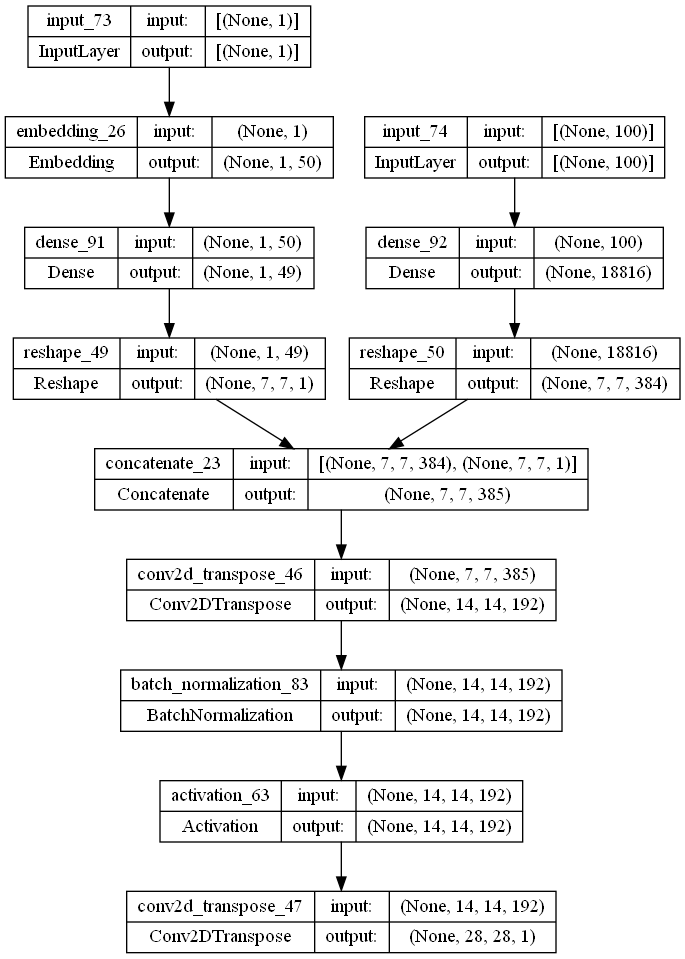

In [118]:
generator = define_generator(latent_dim, num_clases)
# summarize the model
generator.summary()
# plot the model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Red discriminadora

Ahora que tenemos el generador, procedemos a crear un discriminador, que en este caso nos dirá no solo si es auténtica o falsa, sino de cuál clase es.

La utilización de dropouts no es solo para reducir el sobreajuste, sino por cómo funciona una GAN, en la que para que se vaya aprendiendo la red competidora debe fallar un poco, porque si una red aprende demasiado rápido entonces la otra no aprende. Como en nuestro caso lo que nos interesa es falsificar letras y números, nos interesa que el discriminador no aprenda demasiado rápido.

Aquí lo que se hace es realizar convolución para realizar las operaciones inversas al generador, de tal forma que se pase de una imagen de 28x28 a una de 7x7 y se aplane para analizar por las dos salidas indicadas, codificadas como capas Dense, en la que una de ellas tiene una sola neurona de salida que devuelve true/false con binary_crossentropy, y la otra devuelve la clase, que en este caso se codifica la salida como one-hot con categorial_crossentropy, porque en este caso una letra solo puede ser una, no varias. El uso de la activación LeakyRelu con un alfa de 0.2 se utiliza porque según la guía de entrenamiento estable previamente referenciada, es una de las decisiones arquitectónicas que probaron resultar mejores para dicha estabilidad en las DC-GAN (Deep Convolutional GAN), y por consiguiente las AC-GAN.

Lo mismo con usar un Adam con un ratio de aprendizaje bajo y momento moderado, tanto la guía de estabilidad como el artículo sugieren que estos valores hacen que el aprendizaje no sea demasiado lento pero tampoco arriesgándose a ser demasiado inestable.

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 14, 14, 32)   320         ['input_72[0][0]']               
                                                                                                  
 leaky_re_lu_76 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_76[0][0]']              
                                                                                                  
 dropout_76 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_76[0][0]']         
                                                                                      

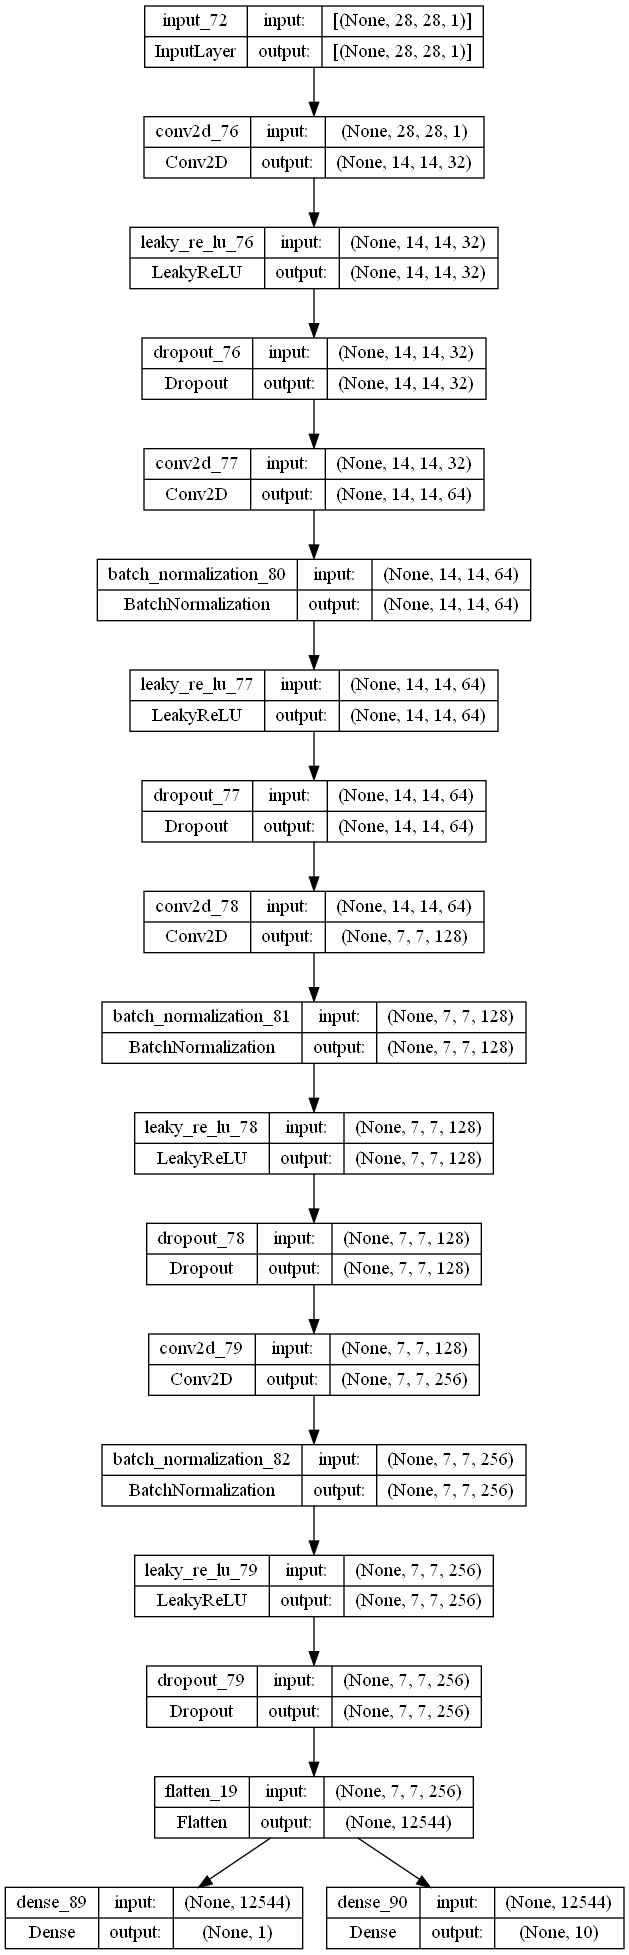

In [115]:
# example of defining the discriminator model
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=47):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2], name='Discriminator')
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_80 (Conv2D)             (None, 14, 14, 32)   320         ['input_75[0][0]']               
                                                                                                  
 leaky_re_lu_80 (LeakyReLU)     (None, 14, 14, 32)   0           ['conv2d_80[0][0]']              
                                                                                                  
 dropout_80 (Dropout)           (None, 14, 14, 32)   0           ['leaky_re_lu_80[0][0]']         
                                                                                      

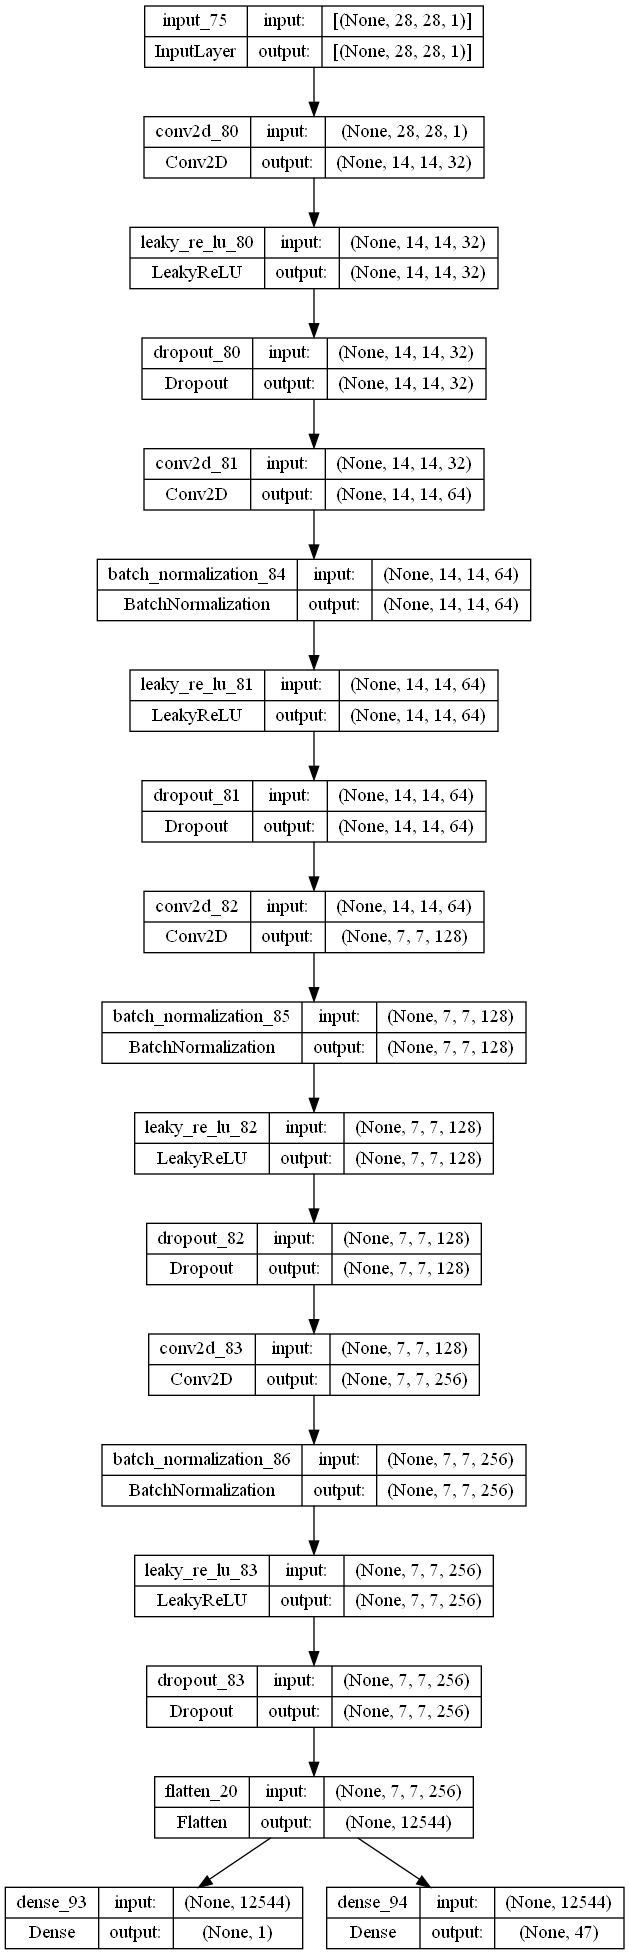

In [123]:
discriminator = define_discriminator(in_shape=(WIDTH, HEIGHT, CHANNELS), n_classes=num_clases)
# summarize the model
discriminator.summary()
# plot the model
plot_model(discriminator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Definición de la arquitectura GAN

Ya disponemos de una red generadora y otra discriminadora. Ahora, antes de realizar la composición del modelo completo, haremos que el discriminador solo sea entrenable invocando su grafo explícitamente, y no desde el gan completo, para permitir entrenar el generador.

De nuevo ajustamos el Adam del modelo total a los parámetros qque heurísticamente han probado ser los mejores según el artículo.

In [132]:
def define_gan(g_model, d_model):
    for layer in d_model.layers:  # Podemos hacer los pesos del discriminador no entrenables
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # conectamos la salida del generador con la entrada del discriminador
    gan_output = d_model(g_model.output)
    # definimos el modelo gan para que tenga el input del generador (tome el ruido y la clase) y nos saque los outputs del discriminador
    model = Model(g_model.input, gan_output)
    # compilación de la GAN
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

In [133]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_73 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        2350        ['input_73[0][0]']               
                                                                                                  
 dense_92 (Dense)               (None, 18816)        1900416     ['input_74[0][0]']               
                                                                                           

## Entrenamiento del modelo GAN

Ahora sí, podemos proceder al entrenamiento. A modo de resumen, el proceso es el siguiente:

1. Definimos el generador y discriminador, y los unimos en un único modelo.
2. Cargamos datos reales.
3. Entrenamos la red, en un bucle. Antes de todo calculamos el número de batches y pasos a realizar - que son 64 y 100 por defecto, respectivamente.
* 3.1 Tomará medio batch (en vez de todas, para que tarde menos, aunque sea algo más lento al aprender) de imágenes reales $\mathcal{R}$, que se indican verdaderas.
* 3.2 Entrenará al discriminador con las muestras auténticas para reconocerlas.
* 3.3 Pedirá al generador crear medio batch de imágenes ficticias $\mathcal{F}$, que se indican adecuadamente como falsas.
* 3.4 Entrenará al discriminador con las muestras falsas para reconocerlas.
* 3.5 Ahora se pedirá al generador crear nuevas muestras falsas $\mathcal{F}$, pero diciendo que son verdaderas.
* 3.6 Se mandan esas muestras a la red GAN entera para entrenarla según el error que de el discriminador - como hemos dicho antes, hemos hecho el discriminador no entrenable cuando está en la GAN así que esto solo entrena al generador.
4. Para hacernos la vida más fácil, cada cierto número de pasos se nos indica como va, y se guarda.

In [124]:
# Paso 2. Cargar imágenes. Para ello es recomendable que pasemos de enteros a flotantes y los normalizemos para prevenir gradientes explosivos.
def load_real_samples():
    # load dataset
    #(trainX, trainy), (_, _) = load_data()
    (trainX, trainy) = extract_training_samples('balanced')
    #(testX, _) = extract_test_samples('balanced')
    # expandir dimensiones, esto también incluye colores, si llegamos a implementarlos
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # escalar [0,255] -> [-1,1] (negro-blanco por como elegir las letras)
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

In [125]:
# elegir muestras reales, 
def generate_real_samples(dataset, n_samples):
    # dividimos el dataset en la imagen y la clase
    images, labels = dataset
    # al azar, del tipo elegido
    ix = randint(0, images.shape[0], n_samples)
    # debemos decirle a la red de qué clase son
    X, labels = images[ix], labels[ix]
    # decimos que son reales
    y = ones((n_samples, 1)) 
    return [X, labels], y

In [128]:
# generar ruido para espacio latente del generador
def generate_latent_points(latent_dim, n_samples, n_classes=47):
    # genero n_samples x latent_dim valores aleatorios y redimensiono para que sean una batch de n ejemplos, cada uno de tamaño latent_dim, para la red
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # para cada una de dichos ejemplos, le asigno una clase aleatoria
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [129]:
# Función de fase 3.3
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generar ruido
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # pedirle crear las imágenes
    images = generator.predict([z_input, labels_input])
    # decimos que son falsas
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [135]:
# Función de fase 4, guardamos el modelo, así como una imagen de como lo genera
def resumir_exito(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # mostrar imágenes por pantalla
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    plt.show()
    # guardar la imagen generada
    archivoImagen = 'generated_plot_%04d.png' % (step+1)
    plt.savefig(archivoImagen)
    plt.close()
    # save the generator model
    nuestroModelo = 'model_%04d.h5' % (step+1)
    g_model.save(nuestroModelo)
    print('>Saved: %s and %s' % (archivoImagen, nuestroModelo))

In [ ]:
# Enternamiento
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=100):
    # Calculamos el número de batches por epoch, nosotros hemos decidido hacerlo de 100 por como estaba en el artículo, es más rápido pero aprende algo más lento
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculo el número de iteraciones
    n_steps = bat_per_epo * n_epochs
    print(n_steps)
    # lo haremos a la mitad de batch
    half_batch = int(n_batch / 2)
    # Enumerar epochs manualmente
    for i in range(n_steps):
        # Tomamos las muestras reales
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # actualizamos el discriminador con las reales
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generamos muestras falsas
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # entrenamos al discriminador con las falsas
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # generamos muestrass falsas, pero esta vez decimos que son reales
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        # entrenando la red ACGAN, calculamos el error del discriminador y actualizamos el generador
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # Esto está aquí solo para ayudarnos a ver que esto realmente progresa por cada batch
        # Es decir, en cada llave, el primer valor nos dice el error de real/fake, y el segundo el error al clasificar la clase.
        # En este caso, nos dice el loss del discriminador cuando se le meten muestras reales (d_r1 y d_r2), y falsas (d_f y d_f2)
        # Y el respectivo del generador (g_1, g_2)
        # los tres valores que están como _  arriba son realmente la suma de las dos loss, por lo que son redundantes
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # guardamos el modelo cada 10 "epochs"
        if (i+1) % (bat_per_epo * 10) == 0:
            resumir_exito(i, g_model, latent_dim)

Una vez hemos definido estas funciones, le damos a la celda de abajo y entrenamos hasta que veamos conveniente. Avisamos que con una gran cantidad de datos la red puede tardar mucho en simplemente realizar 10 de las "epochs" descritas anteriormente.

Por las propiedades de las redes y de como es una red ACGAN, es muy difícil saber cuando parar por métodos puramente numéricos y es muy útil poder hacer valoraciones subjetivas del resultado final con imágenes, y aún así, puede que el resultado no acabe convergiendo. Nosotros hemos decidido pararlo a 10 de estas "epochs", 11280 de los steps, porque cada vez nos iba computando más y más lento - Alejandro estuvo desde 11:00 hasta 0:22 solo para llegar a la epoch 10265, a la 1:00 pasó al paso 10548, a las 2:00 a la epoch 10968.

(112800, 28, 28, 1) (112800,)
112800
2/2 [==============================] - 1s 78ms/step
>1, dr[0.587,1.527], df[0.640,0.430], g[1.116,0.490]
2/2 [==============================] - 0s 70ms/step
>2, dr[0.720,1.800], df[0.978,0.410], g[1.205,0.472]
2/2 [==============================] - 0s 70ms/step
>3, dr[0.698,1.737], df[0.691,0.372], g[1.191,0.367]
2/2 [==============================] - 0s 69ms/step
>4, dr[0.771,1.654], df[0.665,0.565], g[1.302,0.378]
2/2 [==============================] - 0s 68ms/step
>5, dr[0.696,1.983], df[0.818,0.253], g[1.221,0.402]
2/2 [==============================] - 0s 67ms/step
>6, dr[0.611,1.371], df[0.695,0.337], g[1.338,0.340]
2/2 [==============================] - 0s 67ms/step
>7, dr[0.747,2.091], df[0.498,0.315], g[1.041,0.501]
2/2 [==============================] - 0s 70ms/step
>8, dr[0.777,1.336], df[0.790,0.334], g[1.075,0.420]
2/2 [==============================] - 0s 67ms/step
>9, dr[0.763,1.682], df[0.898,0.452], g[1.225,0.362]
2/2 [=============

2/2 [==============================] - 0s 71ms/step
>155, dr[0.575,0.944], df[0.598,0.316], g[1.039,0.374]
2/2 [==============================] - 0s 70ms/step
>156, dr[0.561,1.508], df[0.654,0.134], g[1.331,0.269]
2/2 [==============================] - 0s 69ms/step
>157, dr[0.708,1.997], df[0.798,0.261], g[1.185,0.304]
2/2 [==============================] - 0s 69ms/step
>158, dr[0.655,1.618], df[0.746,0.313], g[1.307,0.311]
2/2 [==============================] - 0s 69ms/step
>159, dr[0.661,1.719], df[0.613,0.398], g[1.232,0.277]
2/2 [==============================] - 0s 68ms/step
>160, dr[0.765,1.331], df[0.781,0.320], g[1.201,0.412]
2/2 [==============================] - 0s 69ms/step
>161, dr[0.619,1.541], df[0.625,0.254], g[1.116,0.434]
2/2 [==============================] - 0s 71ms/step
>162, dr[0.484,1.868], df[0.821,0.322], g[1.253,0.365]
2/2 [==============================] - 0s 70ms/step
>163, dr[0.786,1.379], df[0.647,0.217], g[1.305,0.364]
2/2 [==============================] 

2/2 [==============================] - 0s 67ms/step
>232, dr[0.581,1.328], df[0.690,0.395], g[1.290,0.213]
2/2 [==============================] - 0s 67ms/step
>233, dr[0.701,1.539], df[0.607,0.149], g[1.333,0.339]
2/2 [==============================] - 0s 69ms/step
>234, dr[0.492,1.413], df[0.580,0.194], g[1.229,0.367]
2/2 [==============================] - 0s 70ms/step
>235, dr[0.656,1.783], df[0.499,0.328], g[1.290,0.274]
2/2 [==============================] - 0s 70ms/step
>236, dr[0.809,1.367], df[0.604,0.200], g[1.189,0.253]
2/2 [==============================] - 0s 69ms/step
>237, dr[0.421,1.886], df[0.555,0.386], g[1.288,0.296]
2/2 [==============================] - 0s 68ms/step
>238, dr[0.607,1.234], df[0.572,0.213], g[1.164,0.225]
2/2 [==============================] - 0s 69ms/step
>239, dr[0.771,1.082], df[0.657,0.213], g[1.249,0.273]
2/2 [==============================] - 0s 70ms/step
>240, dr[0.594,1.330], df[0.624,0.248], g[1.269,0.225]
2/2 [==============================] 

2/2 [==============================] - 0s 68ms/step
>309, dr[0.792,1.824], df[0.410,0.211], g[1.337,0.296]
2/2 [==============================] - 0s 71ms/step
>310, dr[0.568,1.737], df[0.586,0.307], g[1.115,0.261]
2/2 [==============================] - 0s 71ms/step
>311, dr[0.585,1.223], df[0.663,0.235], g[1.127,0.228]
2/2 [==============================] - 0s 69ms/step
>312, dr[0.469,1.668], df[0.556,0.208], g[1.444,0.220]
2/2 [==============================] - 0s 69ms/step
>313, dr[0.695,1.763], df[0.652,0.265], g[1.300,0.216]
2/2 [==============================] - 0s 73ms/step
>314, dr[0.466,1.468], df[0.576,0.336], g[1.205,0.277]
2/2 [==============================] - 0s 69ms/step
>315, dr[0.613,1.252], df[0.578,0.386], g[1.350,0.203]
2/2 [==============================] - 0s 69ms/step
>316, dr[0.857,1.790], df[0.587,0.263], g[1.153,0.231]
2/2 [==============================] - 0s 69ms/step
>317, dr[0.483,1.030], df[0.734,0.234], g[1.120,0.235]
2/2 [==============================] 

2/2 [==============================] - 0s 71ms/step
>386, dr[0.565,1.716], df[0.522,0.306], g[1.509,0.286]
2/2 [==============================] - 0s 71ms/step
>387, dr[0.693,1.195], df[0.619,0.253], g[1.489,0.252]
2/2 [==============================] - 0s 70ms/step
>388, dr[0.728,0.926], df[0.525,0.171], g[1.317,0.211]
2/2 [==============================] - 0s 76ms/step
>389, dr[0.592,1.335], df[0.639,0.414], g[1.364,0.252]
2/2 [==============================] - 0s 69ms/step
>390, dr[0.408,1.620], df[0.526,0.246], g[1.252,0.243]
2/2 [==============================] - 0s 71ms/step
>391, dr[0.546,1.268], df[0.552,0.227], g[1.518,0.172]
2/2 [==============================] - 0s 67ms/step
>392, dr[0.645,1.610], df[0.604,0.153], g[1.440,0.209]
2/2 [==============================] - 0s 70ms/step
>393, dr[0.584,0.975], df[0.616,0.272], g[1.577,0.187]
2/2 [==============================] - 0s 70ms/step
>394, dr[0.603,1.236], df[0.584,0.144], g[1.458,0.265]
2/2 [==============================] 

2/2 [==============================] - 0s 70ms/step
>463, dr[0.564,1.383], df[0.525,0.240], g[1.458,0.279]
2/2 [==============================] - 0s 70ms/step
>464, dr[0.469,0.824], df[0.433,0.130], g[1.511,0.170]
2/2 [==============================] - 0s 69ms/step
>465, dr[0.396,1.314], df[0.461,0.208], g[1.423,0.223]
2/2 [==============================] - 0s 73ms/step
>466, dr[0.613,0.872], df[0.611,0.248], g[1.327,0.251]
2/2 [==============================] - 0s 80ms/step
>467, dr[0.480,1.229], df[0.487,0.204], g[1.210,0.264]
2/2 [==============================] - 0s 84ms/step
>468, dr[0.536,1.870], df[0.509,0.178], g[1.333,0.207]
2/2 [==============================] - 0s 71ms/step
>469, dr[0.449,0.974], df[0.676,0.187], g[1.526,0.278]
2/2 [==============================] - 0s 72ms/step
>470, dr[0.591,0.928], df[0.476,0.194], g[1.382,0.323]
2/2 [==============================] - 0s 70ms/step
>471, dr[0.525,1.186], df[0.661,0.180], g[1.480,0.205]
2/2 [==============================] 

2/2 [==============================] - 0s 73ms/step
>540, dr[0.670,1.512], df[0.435,0.162], g[1.377,0.261]
2/2 [==============================] - 0s 72ms/step
>541, dr[0.414,1.074], df[0.572,0.309], g[1.580,0.191]
2/2 [==============================] - 0s 72ms/step
>542, dr[0.416,2.002], df[0.407,0.141], g[1.491,0.193]
2/2 [==============================] - 0s 72ms/step
>543, dr[0.526,1.179], df[0.473,0.223], g[1.350,0.231]
2/2 [==============================] - 0s 71ms/step
>544, dr[0.468,1.020], df[0.396,0.167], g[1.129,0.391]
2/2 [==============================] - 0s 70ms/step
>545, dr[0.400,0.996], df[0.381,0.197], g[1.286,0.252]
2/2 [==============================] - 0s 74ms/step
>546, dr[0.374,1.074], df[0.570,0.149], g[1.431,0.216]
2/2 [==============================] - 0s 76ms/step
>547, dr[0.534,1.121], df[0.316,0.195], g[1.263,0.257]
2/2 [==============================] - 0s 75ms/step
>548, dr[0.548,1.126], df[0.474,0.181], g[1.311,0.225]
2/2 [==============================] 

2/2 [==============================] - 0s 75ms/step
>617, dr[0.359,1.328], df[0.493,0.277], g[1.002,0.228]
2/2 [==============================] - 0s 77ms/step
>618, dr[0.447,1.264], df[0.521,0.100], g[1.112,0.379]
2/2 [==============================] - 0s 78ms/step
>619, dr[0.469,1.137], df[0.478,0.185], g[1.390,0.256]
2/2 [==============================] - 0s 76ms/step
>620, dr[0.619,1.502], df[0.392,0.075], g[1.098,0.300]
2/2 [==============================] - 0s 80ms/step
>621, dr[0.305,1.083], df[0.360,0.146], g[1.252,0.311]
2/2 [==============================] - 0s 77ms/step
>622, dr[0.619,0.966], df[0.560,0.212], g[1.116,0.204]
2/2 [==============================] - 0s 75ms/step
>623, dr[0.474,1.604], df[0.457,0.100], g[1.169,0.222]
2/2 [==============================] - 0s 76ms/step
>624, dr[0.550,1.536], df[0.366,0.179], g[1.008,0.328]
2/2 [==============================] - 0s 79ms/step
>625, dr[0.231,1.015], df[0.397,0.104], g[1.003,0.393]
2/2 [==============================] 

2/2 [==============================] - 0s 80ms/step
>694, dr[0.625,2.037], df[0.674,0.210], g[1.256,0.253]
2/2 [==============================] - 0s 80ms/step
>695, dr[0.511,1.422], df[0.453,0.149], g[1.361,0.242]
2/2 [==============================] - 0s 78ms/step
>696, dr[0.338,1.818], df[0.448,0.196], g[1.340,0.265]
2/2 [==============================] - 0s 78ms/step
>697, dr[0.443,1.505], df[0.493,0.214], g[1.537,0.274]
2/2 [==============================] - 0s 81ms/step
>698, dr[0.531,1.003], df[0.437,0.159], g[1.483,0.197]
2/2 [==============================] - 0s 81ms/step
>699, dr[0.475,1.311], df[0.361,0.095], g[1.388,0.242]
2/2 [==============================] - 0s 80ms/step
>700, dr[0.339,1.032], df[0.520,0.123], g[1.607,0.302]
2/2 [==============================] - 0s 81ms/step
>701, dr[0.461,0.932], df[0.333,0.240], g[1.468,0.215]
2/2 [==============================] - 0s 78ms/step
>702, dr[0.267,2.449], df[0.497,0.231], g[2.066,0.181]
2/2 [==============================] 

2/2 [==============================] - 0s 90ms/step
>771, dr[0.620,1.328], df[0.385,0.114], g[1.624,0.248]
2/2 [==============================] - 0s 89ms/step
>772, dr[0.410,1.566], df[0.692,0.168], g[1.619,0.172]
2/2 [==============================] - 0s 88ms/step
>773, dr[0.463,1.240], df[0.604,0.203], g[1.936,0.187]
2/2 [==============================] - 0s 89ms/step
>774, dr[0.475,1.483], df[0.528,0.144], g[1.956,0.210]
2/2 [==============================] - 0s 92ms/step
>775, dr[0.418,1.422], df[0.315,0.197], g[2.040,0.213]
2/2 [==============================] - 0s 90ms/step
>776, dr[0.590,0.973], df[0.444,0.149], g[1.546,0.194]
2/2 [==============================] - 0s 88ms/step
>777, dr[0.471,1.155], df[0.494,0.193], g[1.654,0.186]
2/2 [==============================] - 0s 87ms/step
>778, dr[0.458,1.031], df[0.464,0.224], g[1.753,0.232]
2/2 [==============================] - 0s 93ms/step
>779, dr[0.448,0.896], df[0.465,0.142], g[1.628,0.213]
2/2 [==============================] 

2/2 [==============================] - 0s 86ms/step
>848, dr[0.555,1.013], df[0.612,0.264], g[1.385,0.271]
2/2 [==============================] - 0s 85ms/step
>849, dr[0.569,0.860], df[0.578,0.219], g[1.511,0.156]
2/2 [==============================] - 0s 84ms/step
>850, dr[0.447,1.420], df[0.404,0.201], g[1.535,0.191]
2/2 [==============================] - 0s 87ms/step
>851, dr[0.498,1.380], df[0.488,0.163], g[1.468,0.225]
2/2 [==============================] - 0s 87ms/step
>852, dr[0.456,1.139], df[0.727,0.133], g[1.548,0.236]
2/2 [==============================] - 0s 87ms/step
>853, dr[0.487,1.015], df[0.408,0.153], g[1.803,0.238]
2/2 [==============================] - 0s 85ms/step
>854, dr[0.529,1.202], df[0.509,0.245], g[1.571,0.174]
2/2 [==============================] - 0s 88ms/step
>855, dr[0.531,1.113], df[0.470,0.207], g[1.701,0.232]
2/2 [==============================] - 0s 88ms/step
>856, dr[0.424,0.878], df[0.724,0.202], g[1.646,0.253]
2/2 [==============================] 

2/2 [==============================] - 0s 86ms/step
>925, dr[0.469,1.435], df[0.543,0.177], g[1.763,0.229]
2/2 [==============================] - 0s 85ms/step
>926, dr[0.740,1.803], df[0.602,0.216], g[1.644,0.135]
2/2 [==============================] - 0s 84ms/step
>927, dr[0.700,1.563], df[0.613,0.181], g[1.554,0.205]
2/2 [==============================] - 0s 86ms/step
>928, dr[0.366,1.088], df[0.542,0.257], g[1.878,0.197]
2/2 [==============================] - 0s 82ms/step
>929, dr[0.524,1.170], df[0.467,0.182], g[1.757,0.312]
2/2 [==============================] - 0s 85ms/step
>930, dr[0.444,1.161], df[0.552,0.098], g[1.811,0.196]
2/2 [==============================] - 0s 87ms/step
>931, dr[0.550,1.054], df[0.487,0.259], g[1.689,0.205]
2/2 [==============================] - 0s 86ms/step
>932, dr[0.531,0.926], df[0.414,0.239], g[1.510,0.267]
2/2 [==============================] - 0s 85ms/step
>933, dr[0.633,1.358], df[0.724,0.139], g[1.399,0.214]
2/2 [==============================] 

2/2 [==============================] - 0s 85ms/step
>1002, dr[0.550,1.099], df[0.415,0.117], g[1.666,0.195]
2/2 [==============================] - 0s 87ms/step
>1003, dr[0.437,1.311], df[0.584,0.219], g[1.973,0.188]
2/2 [==============================] - 0s 90ms/step
>1004, dr[0.576,1.424], df[0.566,0.228], g[1.603,0.188]
2/2 [==============================] - 0s 92ms/step
>1005, dr[0.331,1.461], df[0.389,0.128], g[1.797,0.195]
2/2 [==============================] - 0s 89ms/step
>1006, dr[0.692,1.206], df[0.603,0.210], g[1.512,0.207]
2/2 [==============================] - 0s 88ms/step
>1007, dr[0.583,0.794], df[0.505,0.241], g[1.445,0.283]
2/2 [==============================] - 0s 86ms/step
>1008, dr[0.492,0.958], df[0.483,0.435], g[1.304,0.160]
2/2 [==============================] - 0s 86ms/step
>1009, dr[0.445,1.223], df[0.510,0.149], g[1.597,0.199]
2/2 [==============================] - 0s 86ms/step
>1010, dr[0.330,0.858], df[0.709,0.281], g[1.878,0.183]
2/2 [=======================

2/2 [==============================] - 0s 86ms/step
>1078, dr[0.404,1.279], df[0.473,0.178], g[1.701,0.195]
2/2 [==============================] - 0s 86ms/step
>1079, dr[0.552,1.026], df[0.383,0.137], g[1.410,0.277]
2/2 [==============================] - 0s 88ms/step
>1080, dr[0.509,1.218], df[0.465,0.191], g[1.383,0.258]
2/2 [==============================] - 0s 87ms/step
>1081, dr[0.409,1.103], df[0.608,0.093], g[1.606,0.224]
2/2 [==============================] - 0s 92ms/step
>1082, dr[0.393,0.669], df[0.483,0.163], g[1.331,0.183]
2/2 [==============================] - 0s 88ms/step
>1083, dr[0.641,1.026], df[0.562,0.166], g[1.642,0.159]
2/2 [==============================] - 0s 88ms/step
>1084, dr[0.419,1.369], df[0.482,0.129], g[1.406,0.221]
2/2 [==============================] - 0s 90ms/step
>1085, dr[0.464,0.851], df[0.532,0.175], g[1.595,0.141]
2/2 [==============================] - 0s 91ms/step
>1086, dr[0.535,1.021], df[0.515,0.142], g[1.457,0.245]
2/2 [=======================

2/2 [==============================] - 0s 86ms/step
>1154, dr[0.550,1.165], df[0.495,0.157], g[1.691,0.161]
2/2 [==============================] - 0s 87ms/step
>1155, dr[0.485,1.014], df[0.503,0.255], g[1.763,0.154]
2/2 [==============================] - 0s 86ms/step
>1156, dr[0.436,1.083], df[0.585,0.231], g[1.967,0.234]
2/2 [==============================] - 0s 86ms/step
>1157, dr[0.493,1.390], df[0.295,0.082], g[1.616,0.146]
2/2 [==============================] - 0s 86ms/step
>1158, dr[0.521,1.238], df[0.529,0.170], g[1.564,0.224]
2/2 [==============================] - 0s 84ms/step
>1159, dr[0.399,1.223], df[0.477,0.196], g[1.639,0.172]
2/2 [==============================] - 0s 84ms/step
>1160, dr[0.342,0.894], df[0.433,0.188], g[1.963,0.206]
2/2 [==============================] - 0s 85ms/step
>1161, dr[0.505,1.137], df[0.370,0.167], g[1.826,0.182]
2/2 [==============================] - 0s 86ms/step
>1162, dr[0.480,0.852], df[0.557,0.239], g[1.842,0.129]
2/2 [=======================

2/2 [==============================] - 0s 84ms/step
>1230, dr[0.648,1.189], df[0.405,0.304], g[1.810,0.167]
2/2 [==============================] - 0s 82ms/step
>1231, dr[0.630,1.136], df[0.545,0.237], g[1.756,0.206]
2/2 [==============================] - 0s 85ms/step
>1232, dr[0.455,1.123], df[0.488,0.221], g[1.232,0.228]
2/2 [==============================] - 0s 84ms/step
>1233, dr[0.497,0.903], df[0.531,0.141], g[1.584,0.187]
2/2 [==============================] - 0s 81ms/step
>1234, dr[0.452,0.988], df[0.623,0.153], g[1.492,0.243]
2/2 [==============================] - 0s 85ms/step
>1235, dr[0.424,0.908], df[0.568,0.132], g[1.742,0.164]
2/2 [==============================] - 0s 87ms/step
>1236, dr[0.555,1.046], df[0.308,0.182], g[1.618,0.194]
2/2 [==============================] - 0s 84ms/step
>1237, dr[0.469,0.922], df[0.418,0.117], g[1.658,0.231]
2/2 [==============================] - 0s 83ms/step
>1238, dr[0.544,0.570], df[0.640,0.246], g[1.594,0.133]
2/2 [=======================

2/2 [==============================] - 0s 83ms/step
>1306, dr[0.440,1.004], df[0.472,0.244], g[1.520,0.196]
2/2 [==============================] - 0s 85ms/step
>1307, dr[0.517,1.118], df[0.527,0.269], g[1.764,0.191]
2/2 [==============================] - 0s 87ms/step
>1308, dr[0.513,1.252], df[0.397,0.230], g[1.404,0.217]
2/2 [==============================] - 0s 88ms/step
>1309, dr[0.335,0.893], df[0.480,0.187], g[1.586,0.179]
2/2 [==============================] - 0s 87ms/step
>1310, dr[0.558,0.611], df[0.421,0.146], g[1.376,0.172]
2/2 [==============================] - 0s 82ms/step
>1311, dr[0.431,0.794], df[0.475,0.129], g[1.369,0.141]
2/2 [==============================] - 0s 81ms/step
>1312, dr[0.436,1.113], df[0.514,0.279], g[1.576,0.207]
2/2 [==============================] - 0s 81ms/step
>1313, dr[0.478,1.405], df[0.343,0.351], g[1.533,0.160]
2/2 [==============================] - 0s 84ms/step
>1314, dr[0.544,1.234], df[0.410,0.199], g[1.216,0.177]
2/2 [=======================

2/2 [==============================] - 0s 81ms/step
>1382, dr[0.381,0.926], df[0.439,0.150], g[1.590,0.188]
2/2 [==============================] - 0s 81ms/step
>1383, dr[0.469,1.142], df[0.582,0.214], g[1.446,0.246]
2/2 [==============================] - 0s 81ms/step
>1384, dr[0.450,1.084], df[0.620,0.228], g[1.772,0.225]
2/2 [==============================] - 0s 79ms/step
>1385, dr[0.585,0.833], df[0.527,0.197], g[1.941,0.185]
2/2 [==============================] - 0s 79ms/step
>1386, dr[0.538,1.160], df[0.408,0.113], g[1.665,0.184]
2/2 [==============================] - 0s 79ms/step
>1387, dr[0.668,1.301], df[0.577,0.151], g[1.497,0.213]
2/2 [==============================] - 0s 83ms/step
>1388, dr[0.575,0.788], df[0.633,0.268], g[1.462,0.182]
2/2 [==============================] - 0s 79ms/step
>1389, dr[0.376,1.240], df[0.461,0.199], g[1.613,0.160]
2/2 [==============================] - 0s 79ms/step
>1390, dr[0.575,0.877], df[0.475,0.096], g[1.451,0.210]
2/2 [=======================

2/2 [==============================] - 0s 82ms/step
>1458, dr[0.388,1.151], df[0.491,0.234], g[1.650,0.242]
2/2 [==============================] - 0s 83ms/step
>1459, dr[0.527,0.926], df[0.544,0.248], g[1.667,0.190]
2/2 [==============================] - 0s 82ms/step
>1460, dr[0.512,0.700], df[0.553,0.144], g[1.853,0.164]
2/2 [==============================] - 0s 82ms/step
>1461, dr[0.643,1.062], df[0.493,0.290], g[1.478,0.223]
2/2 [==============================] - 0s 80ms/step
>1462, dr[0.413,1.198], df[0.491,0.175], g[1.382,0.229]
2/2 [==============================] - 0s 80ms/step
>1463, dr[0.505,0.853], df[0.467,0.110], g[1.412,0.262]
2/2 [==============================] - 0s 80ms/step
>1464, dr[0.478,0.915], df[0.577,0.196], g[1.331,0.154]
2/2 [==============================] - 0s 81ms/step
>1465, dr[0.504,1.405], df[0.515,0.079], g[1.635,0.191]
2/2 [==============================] - 0s 79ms/step
>1466, dr[0.544,1.116], df[0.486,0.123], g[1.671,0.215]
2/2 [=======================

2/2 [==============================] - 0s 99ms/step
>1534, dr[0.454,1.025], df[0.430,0.175], g[1.270,0.093]
2/2 [==============================] - 0s 97ms/step
>1535, dr[0.500,0.598], df[0.481,0.186], g[1.537,0.146]
2/2 [==============================] - 0s 97ms/step
>1536, dr[0.384,1.268], df[0.471,0.094], g[1.478,0.127]
2/2 [==============================] - 0s 94ms/step
>1537, dr[0.396,1.264], df[0.408,0.112], g[1.693,0.157]
2/2 [==============================] - 0s 95ms/step
>1538, dr[0.519,1.392], df[0.433,0.123], g[1.364,0.206]
2/2 [==============================] - 0s 94ms/step
>1539, dr[0.468,0.869], df[0.682,0.170], g[1.791,0.171]
2/2 [==============================] - 0s 98ms/step
>1540, dr[0.641,1.039], df[0.388,0.102], g[1.569,0.265]
2/2 [==============================] - 0s 96ms/step
>1541, dr[0.510,1.168], df[0.466,0.148], g[1.390,0.220]
2/2 [==============================] - 0s 99ms/step
>1542, dr[0.474,0.800], df[0.577,0.329], g[1.488,0.188]
2/2 [=======================

2/2 [==============================] - 0s 92ms/step
>1610, dr[0.387,1.132], df[0.633,0.197], g[1.506,0.189]
2/2 [==============================] - 0s 91ms/step
>1611, dr[0.549,1.143], df[0.503,0.173], g[1.667,0.134]
2/2 [==============================] - 0s 98ms/step
>1612, dr[0.451,0.732], df[0.545,0.195], g[1.829,0.135]
2/2 [==============================] - 0s 98ms/step
>1613, dr[0.737,1.218], df[0.384,0.120], g[1.159,0.272]
2/2 [==============================] - 0s 96ms/step
>1614, dr[0.470,0.634], df[0.573,0.170], g[1.270,0.168]
2/2 [==============================] - 0s 96ms/step
>1615, dr[0.350,1.783], df[0.515,0.210], g[1.634,0.205]
2/2 [==============================] - 0s 92ms/step
>1616, dr[0.479,1.089], df[0.501,0.175], g[1.398,0.229]
2/2 [==============================] - 0s 93ms/step
>1617, dr[0.609,1.049], df[0.573,0.206], g[1.447,0.225]
2/2 [==============================] - 0s 93ms/step
>1618, dr[0.522,0.877], df[0.524,0.356], g[1.408,0.161]
2/2 [=======================

2/2 [==============================] - 0s 86ms/step
>1686, dr[0.701,1.422], df[0.465,0.144], g[1.268,0.184]
2/2 [==============================] - 0s 86ms/step
>1687, dr[0.304,1.068], df[0.446,0.186], g[1.483,0.124]
2/2 [==============================] - 0s 85ms/step
>1688, dr[0.454,1.073], df[0.573,0.186], g[1.278,0.209]
2/2 [==============================] - 0s 84ms/step
>1689, dr[0.522,0.868], df[0.550,0.186], g[1.658,0.152]
2/2 [==============================] - 0s 86ms/step
>1690, dr[0.524,1.411], df[0.421,0.086], g[1.374,0.144]
2/2 [==============================] - 0s 84ms/step
>1691, dr[0.552,0.755], df[0.317,0.110], g[1.329,0.156]
2/2 [==============================] - 0s 89ms/step
>1692, dr[0.412,1.108], df[0.655,0.118], g[1.303,0.163]
2/2 [==============================] - 0s 90ms/step
>1693, dr[0.441,1.519], df[0.373,0.225], g[1.334,0.235]
2/2 [==============================] - 0s 85ms/step
>1694, dr[0.423,0.848], df[0.600,0.134], g[1.706,0.106]
2/2 [=======================

2/2 [==============================] - 0s 79ms/step
>1762, dr[0.416,0.972], df[0.587,0.188], g[1.456,0.144]
2/2 [==============================] - 0s 79ms/step
>1763, dr[0.575,0.743], df[0.556,0.101], g[1.591,0.250]
2/2 [==============================] - 0s 86ms/step
>1764, dr[0.571,1.015], df[0.413,0.105], g[1.499,0.223]
2/2 [==============================] - 0s 79ms/step
>1765, dr[0.525,0.884], df[0.473,0.128], g[1.538,0.114]
2/2 [==============================] - 0s 79ms/step
>1766, dr[0.352,0.486], df[0.485,0.208], g[1.619,0.171]
2/2 [==============================] - 0s 78ms/step
>1767, dr[0.418,0.978], df[0.432,0.103], g[1.708,0.139]
2/2 [==============================] - 0s 78ms/step
>1768, dr[0.535,0.912], df[0.530,0.162], g[1.705,0.095]
2/2 [==============================] - 0s 80ms/step
>1769, dr[0.507,0.713], df[0.582,0.183], g[1.616,0.172]
2/2 [==============================] - 0s 76ms/step
>1770, dr[0.483,1.009], df[0.413,0.110], g[1.678,0.185]
2/2 [=======================

2/2 [==============================] - 0s 81ms/step
>1838, dr[0.464,1.095], df[0.422,0.161], g[1.577,0.121]
2/2 [==============================] - 0s 78ms/step
>1839, dr[0.544,1.458], df[0.609,0.144], g[1.525,0.096]
2/2 [==============================] - 0s 76ms/step
>1840, dr[0.521,1.376], df[0.530,0.123], g[1.388,0.132]
2/2 [==============================] - 0s 75ms/step
>1841, dr[0.490,0.741], df[0.616,0.124], g[1.523,0.114]
2/2 [==============================] - 0s 75ms/step
>1842, dr[0.464,0.685], df[0.425,0.166], g[1.636,0.139]
2/2 [==============================] - 0s 75ms/step
>1843, dr[0.584,0.812], df[0.641,0.204], g[1.601,0.202]
2/2 [==============================] - 0s 79ms/step
>1844, dr[0.463,0.650], df[0.439,0.147], g[1.710,0.117]
2/2 [==============================] - 0s 84ms/step
>1845, dr[0.641,0.941], df[0.577,0.140], g[1.331,0.152]
2/2 [==============================] - 0s 78ms/step
>1846, dr[0.439,0.716], df[0.473,0.093], g[1.421,0.185]
2/2 [=======================

2/2 [==============================] - 0s 79ms/step
>1914, dr[0.491,1.289], df[0.525,0.139], g[1.472,0.122]
2/2 [==============================] - 0s 76ms/step
>1915, dr[0.686,0.918], df[0.421,0.174], g[1.315,0.108]
2/2 [==============================] - 0s 80ms/step
>1916, dr[0.399,0.944], df[0.725,0.267], g[1.473,0.146]
2/2 [==============================] - 0s 80ms/step
>1917, dr[0.411,0.695], df[0.520,0.137], g[1.769,0.191]
2/2 [==============================] - 0s 77ms/step
>1918, dr[0.697,1.075], df[0.504,0.106], g[1.330,0.154]
2/2 [==============================] - 0s 80ms/step
>1919, dr[0.334,1.197], df[0.421,0.141], g[1.242,0.128]
2/2 [==============================] - 0s 78ms/step
>1920, dr[0.500,1.336], df[0.616,0.108], g[1.644,0.106]
2/2 [==============================] - 0s 78ms/step
>1921, dr[0.480,0.820], df[0.454,0.119], g[1.573,0.106]
2/2 [==============================] - 0s 77ms/step
>1922, dr[0.622,1.133], df[0.515,0.067], g[1.541,0.094]
2/2 [=======================

2/2 [==============================] - 0s 79ms/step
>1990, dr[0.720,1.169], df[0.545,0.107], g[1.589,0.135]
2/2 [==============================] - 0s 79ms/step
>1991, dr[0.423,1.341], df[0.516,0.132], g[1.377,0.167]
2/2 [==============================] - 0s 83ms/step
>1992, dr[0.506,1.050], df[0.474,0.188], g[1.333,0.153]
2/2 [==============================] - 0s 80ms/step
>1993, dr[0.477,0.595], df[0.432,0.154], g[1.548,0.109]
2/2 [==============================] - 0s 83ms/step
>1994, dr[0.443,0.794], df[0.619,0.212], g[1.642,0.096]
2/2 [==============================] - 0s 78ms/step
>1995, dr[0.413,0.850], df[0.640,0.091], g[1.661,0.173]
2/2 [==============================] - 0s 82ms/step
>1996, dr[0.776,0.991], df[0.496,0.044], g[1.624,0.071]
2/2 [==============================] - 0s 82ms/step
>1997, dr[0.847,0.850], df[0.412,0.155], g[1.211,0.113]
2/2 [==============================] - 0s 81ms/step
>1998, dr[0.403,0.872], df[0.617,0.142], g[1.252,0.152]
2/2 [=======================

2/2 [==============================] - 0s 77ms/step
>2066, dr[0.429,0.767], df[0.493,0.141], g[1.327,0.151]
2/2 [==============================] - 0s 76ms/step
>2067, dr[0.381,1.015], df[0.536,0.146], g[1.437,0.133]
2/2 [==============================] - 0s 78ms/step
>2068, dr[0.351,1.335], df[0.552,0.145], g[1.653,0.093]
2/2 [==============================] - 0s 77ms/step
>2069, dr[0.499,1.112], df[0.437,0.191], g[1.623,0.114]
2/2 [==============================] - 0s 78ms/step
>2070, dr[0.736,0.807], df[0.453,0.136], g[1.300,0.089]
2/2 [==============================] - 0s 79ms/step
>2071, dr[0.413,0.839], df[0.566,0.079], g[1.398,0.107]
2/2 [==============================] - 0s 76ms/step
>2072, dr[0.541,1.053], df[0.773,0.151], g[1.484,0.193]
2/2 [==============================] - 0s 75ms/step
>2073, dr[0.486,0.658], df[0.495,0.107], g[1.617,0.135]
2/2 [==============================] - 0s 75ms/step
>2074, dr[0.650,0.843], df[0.465,0.157], g[1.346,0.148]
2/2 [=======================

2/2 [==============================] - 0s 82ms/step
>2142, dr[0.428,0.947], df[0.643,0.133], g[1.452,0.166]
2/2 [==============================] - 0s 79ms/step
>2143, dr[0.488,0.939], df[0.505,0.092], g[1.518,0.169]
2/2 [==============================] - 0s 78ms/step
>2144, dr[0.544,1.130], df[0.473,0.115], g[1.596,0.101]
2/2 [==============================] - 0s 79ms/step
>2145, dr[0.492,0.823], df[0.518,0.092], g[1.769,0.136]
2/2 [==============================] - 0s 78ms/step
>2146, dr[0.569,0.645], df[0.419,0.124], g[1.410,0.153]
2/2 [==============================] - 0s 79ms/step
>2147, dr[0.528,1.242], df[0.430,0.089], g[1.281,0.112]
2/2 [==============================] - 0s 81ms/step
>2148, dr[0.365,0.925], df[0.567,0.150], g[1.474,0.072]
2/2 [==============================] - 0s 84ms/step
>2149, dr[0.600,0.984], df[0.435,0.112], g[1.486,0.083]
2/2 [==============================] - 0s 81ms/step
>2150, dr[0.444,0.898], df[0.447,0.094], g[1.442,0.140]
2/2 [=======================

2/2 [==============================] - 0s 80ms/step
>2218, dr[0.465,0.775], df[0.773,0.166], g[1.594,0.137]
2/2 [==============================] - 0s 82ms/step
>2219, dr[0.446,1.026], df[0.546,0.092], g[1.636,0.117]
2/2 [==============================] - 0s 89ms/step
>2220, dr[0.819,1.195], df[0.436,0.108], g[1.395,0.087]
2/2 [==============================] - 0s 85ms/step
>2221, dr[0.674,0.740], df[0.391,0.131], g[1.217,0.100]
2/2 [==============================] - 0s 83ms/step
>2222, dr[0.560,1.041], df[0.764,0.085], g[1.162,0.092]
2/2 [==============================] - 0s 81ms/step
>2223, dr[0.451,1.460], df[0.649,0.111], g[1.380,0.170]
2/2 [==============================] - 0s 81ms/step
>2224, dr[0.583,0.834], df[0.542,0.064], g[1.493,0.132]
2/2 [==============================] - 0s 82ms/step
>2225, dr[0.418,1.057], df[0.546,0.092], g[1.433,0.097]
2/2 [==============================] - 0s 84ms/step
>2226, dr[0.497,0.935], df[0.358,0.125], g[1.492,0.096]
2/2 [=======================

2/2 [==============================] - 0s 82ms/step
>2294, dr[0.617,1.046], df[0.620,0.247], g[1.330,0.101]
2/2 [==============================] - 0s 82ms/step
>2295, dr[0.619,1.014], df[0.765,0.086], g[1.305,0.127]
2/2 [==============================] - 0s 82ms/step
>2296, dr[0.601,1.205], df[0.468,0.140], g[1.273,0.075]
2/2 [==============================] - 0s 82ms/step
>2297, dr[0.512,0.893], df[0.666,0.081], g[1.266,0.119]
2/2 [==============================] - 0s 83ms/step
>2298, dr[0.419,1.074], df[0.533,0.104], g[1.400,0.140]
2/2 [==============================] - 0s 80ms/step
>2299, dr[0.719,1.069], df[0.591,0.089], g[1.609,0.109]
2/2 [==============================] - 0s 86ms/step
>2300, dr[0.563,0.738], df[0.692,0.214], g[1.335,0.099]
2/2 [==============================] - 0s 84ms/step
>2301, dr[0.662,0.969], df[0.560,0.142], g[1.477,0.106]
2/2 [==============================] - 0s 84ms/step
>2302, dr[0.457,0.934], df[0.457,0.282], g[1.466,0.095]
2/2 [=======================

2/2 [==============================] - 0s 108ms/step
>2370, dr[0.356,0.849], df[0.470,0.092], g[1.351,0.086]
2/2 [==============================] - 0s 106ms/step
>2371, dr[0.753,1.255], df[0.521,0.069], g[1.308,0.160]
2/2 [==============================] - 0s 116ms/step
>2372, dr[0.461,1.132], df[0.481,0.171], g[1.201,0.132]
2/2 [==============================] - 0s 106ms/step
>2373, dr[0.442,1.005], df[0.587,0.132], g[1.401,0.103]
2/2 [==============================] - 0s 107ms/step
>2374, dr[0.544,0.804], df[0.443,0.088], g[1.148,0.076]
2/2 [==============================] - 0s 106ms/step
>2375, dr[0.621,1.077], df[0.549,0.100], g[1.209,0.077]
2/2 [==============================] - 0s 108ms/step
>2376, dr[0.530,0.937], df[0.606,0.149], g[1.376,0.103]
2/2 [==============================] - 0s 105ms/step
>2377, dr[0.533,1.151], df[0.638,0.127], g[1.278,0.116]
2/2 [==============================] - 0s 104ms/step
>2378, dr[0.589,0.878], df[0.722,0.121], g[1.445,0.067]
2/2 [==============

2/2 [==============================] - 0s 101ms/step
>2520, dr[0.571,0.994], df[0.633,0.151], g[1.376,0.106]
2/2 [==============================] - 0s 113ms/step
>2521, dr[0.630,1.063], df[0.706,0.136], g[1.322,0.115]
2/2 [==============================] - 0s 105ms/step
>2522, dr[0.606,0.793], df[0.499,0.152], g[1.409,0.093]
2/2 [==============================] - 0s 100ms/step
>2523, dr[0.486,0.970], df[0.471,0.059], g[1.510,0.094]
2/2 [==============================] - 0s 102ms/step
>2524, dr[0.628,0.776], df[0.592,0.146], g[1.217,0.067]
2/2 [==============================] - 0s 102ms/step
>2525, dr[0.482,0.782], df[0.394,0.082], g[1.332,0.123]
2/2 [==============================] - 0s 103ms/step
>2526, dr[0.699,0.663], df[0.655,0.078], g[1.237,0.144]
2/2 [==============================] - 0s 101ms/step
>2527, dr[0.705,1.137], df[0.792,0.208], g[1.184,0.097]
2/2 [==============================] - 0s 101ms/step
>2528, dr[0.579,0.905], df[0.495,0.093], g[1.237,0.119]
2/2 [==============

2/2 [==============================] - 0s 105ms/step
>2670, dr[0.621,0.794], df[0.559,0.148], g[1.315,0.158]
2/2 [==============================] - 0s 121ms/step
>2671, dr[0.551,0.660], df[0.432,0.185], g[1.292,0.065]
2/2 [==============================] - 0s 127ms/step
>2672, dr[0.480,0.697], df[0.560,0.106], g[1.306,0.077]
2/2 [==============================] - 1s 222ms/step
>2673, dr[0.575,0.830], df[0.553,0.077], g[1.227,0.078]
2/2 [==============================] - 0s 101ms/step
>2674, dr[0.600,0.941], df[0.584,0.059], g[1.210,0.104]
2/2 [==============================] - 0s 175ms/step
>2675, dr[0.471,1.031], df[0.418,0.068], g[1.379,0.080]
2/2 [==============================] - 1s 209ms/step
>2676, dr[0.516,1.121], df[0.659,0.151], g[1.355,0.091]
2/2 [==============================] - 0s 130ms/step
>2677, dr[0.557,0.776], df[0.510,0.165], g[1.256,0.084]
2/2 [==============================] - 1s 158ms/step
>2678, dr[0.564,0.889], df[0.544,0.133], g[1.353,0.114]
2/2 [==============

2/2 [==============================] - 0s 196ms/step
>2820, dr[0.633,0.895], df[0.653,0.078], g[1.205,0.085]
2/2 [==============================] - 0s 201ms/step
>2821, dr[0.555,0.969], df[0.514,0.061], g[1.320,0.067]
2/2 [==============================] - 1s 209ms/step
>2822, dr[0.645,0.946], df[0.587,0.141], g[1.170,0.123]
2/2 [==============================] - 1s 189ms/step
>2823, dr[0.462,0.667], df[0.496,0.160], g[1.279,0.100]
2/2 [==============================] - 0s 189ms/step
>2824, dr[0.499,0.931], df[0.452,0.058], g[1.290,0.092]
2/2 [==============================] - 1s 191ms/step
>2825, dr[0.479,0.933], df[0.537,0.105], g[1.244,0.074]
2/2 [==============================] - 1s 200ms/step
>2826, dr[0.460,0.864], df[0.717,0.108], g[1.388,0.060]
2/2 [==============================] - 1s 217ms/step
>2827, dr[0.617,0.734], df[0.522,0.090], g[1.399,0.067]
2/2 [==============================] - 0s 166ms/step
>2828, dr[0.605,0.894], df[0.606,0.079], g[1.315,0.086]
2/2 [==============

2/2 [==============================] - 0s 113ms/step
>2970, dr[0.549,0.675], df[0.573,0.156], g[1.341,0.112]
2/2 [==============================] - 0s 117ms/step
>2971, dr[0.682,0.637], df[0.640,0.105], g[1.361,0.096]
2/2 [==============================] - 0s 117ms/step
>2972, dr[0.603,0.786], df[0.472,0.128], g[1.370,0.071]
2/2 [==============================] - 0s 116ms/step
>2973, dr[0.598,0.989], df[0.530,0.127], g[1.296,0.088]
2/2 [==============================] - 0s 118ms/step
>2974, dr[0.576,0.759], df[0.584,0.100], g[1.255,0.098]
2/2 [==============================] - 0s 118ms/step
>2975, dr[0.582,0.867], df[0.689,0.082], g[1.197,0.096]
2/2 [==============================] - 0s 173ms/step
>2976, dr[0.558,0.975], df[0.470,0.061], g[1.116,0.103]
2/2 [==============================] - 1s 228ms/step
>2977, dr[0.584,0.692], df[0.704,0.070], g[1.291,0.062]
2/2 [==============================] - 1s 192ms/step
>2978, dr[0.579,0.738], df[0.541,0.237], g[1.136,0.102]
2/2 [==============

2/2 [==============================] - 1s 207ms/step
>3120, dr[0.622,0.866], df[0.490,0.127], g[1.191,0.097]
2/2 [==============================] - 0s 177ms/step
>3121, dr[0.574,0.659], df[0.607,0.059], g[1.253,0.109]
2/2 [==============================] - 0s 160ms/step
>3122, dr[0.683,1.115], df[0.733,0.080], g[1.285,0.159]
2/2 [==============================] - 0s 169ms/step
>3123, dr[0.638,1.003], df[0.635,0.171], g[1.250,0.078]
2/2 [==============================] - 1s 179ms/step
>3124, dr[0.496,1.208], df[0.696,0.100], g[1.175,0.079]
2/2 [==============================] - 1s 178ms/step
>3125, dr[0.520,1.091], df[0.534,0.067], g[1.340,0.102]
2/2 [==============================] - 1s 180ms/step
>3126, dr[0.902,0.971], df[0.543,0.130], g[1.212,0.076]
2/2 [==============================] - 1s 178ms/step
>3127, dr[0.554,1.307], df[0.558,0.074], g[1.081,0.074]
2/2 [==============================] - 1s 221ms/step
>3128, dr[0.546,1.125], df[0.524,0.055], g[1.062,0.125]
2/2 [==============

2/2 [==============================] - 1s 186ms/step
>3270, dr[0.545,1.167], df[0.509,0.146], g[1.131,0.090]
2/2 [==============================] - 1s 186ms/step
>3271, dr[0.485,0.574], df[0.601,0.096], g[1.297,0.050]
2/2 [==============================] - 1s 212ms/step
>3272, dr[0.641,0.894], df[0.528,0.126], g[1.217,0.086]
2/2 [==============================] - 1s 219ms/step
>3273, dr[0.574,0.725], df[0.535,0.080], g[1.127,0.076]
2/2 [==============================] - 0s 149ms/step
>3274, dr[0.603,1.210], df[0.576,0.093], g[1.203,0.122]
2/2 [==============================] - 0s 149ms/step
>3275, dr[0.561,0.669], df[0.608,0.105], g[1.162,0.131]
2/2 [==============================] - 0s 145ms/step
>3276, dr[0.522,0.758], df[0.793,0.122], g[1.090,0.114]
2/2 [==============================] - 0s 155ms/step
>3277, dr[0.606,1.289], df[0.589,0.082], g[1.209,0.078]
2/2 [==============================] - 0s 151ms/step
>3278, dr[0.521,0.658], df[0.530,0.195], g[1.243,0.183]
2/2 [==============

2/2 [==============================] - 0s 145ms/step
>3420, dr[0.577,0.926], df[0.495,0.067], g[1.141,0.115]
2/2 [==============================] - 1s 207ms/step
>3421, dr[0.494,0.662], df[0.594,0.073], g[1.203,0.080]
2/2 [==============================] - 1s 197ms/step
>3422, dr[0.638,0.734], df[0.615,0.088], g[1.276,0.089]
2/2 [==============================] - 1s 221ms/step
>3423, dr[0.651,0.750], df[0.490,0.096], g[1.161,0.063]
2/2 [==============================] - 1s 212ms/step
>3424, dr[0.503,0.513], df[0.578,0.072], g[1.135,0.100]
2/2 [==============================] - 1s 200ms/step
>3425, dr[0.574,0.644], df[0.561,0.144], g[1.213,0.073]
2/2 [==============================] - 1s 190ms/step
>3426, dr[0.642,0.627], df[0.613,0.054], g[1.101,0.083]
2/2 [==============================] - 1s 214ms/step
>3427, dr[0.493,0.905], df[0.630,0.059], g[1.251,0.081]
2/2 [==============================] - 1s 198ms/step
>3428, dr[0.702,0.686], df[0.620,0.061], g[1.290,0.065]
2/2 [==============

2/2 [==============================] - 0s 159ms/step
>3570, dr[0.573,0.984], df[0.501,0.156], g[1.138,0.157]
2/2 [==============================] - 0s 159ms/step
>3571, dr[0.528,1.051], df[0.683,0.091], g[1.200,0.079]
2/2 [==============================] - 0s 154ms/step
>3572, dr[0.625,0.491], df[0.598,0.049], g[1.185,0.062]
2/2 [==============================] - 0s 160ms/step
>3573, dr[0.781,0.771], df[0.611,0.100], g[1.177,0.076]
2/2 [==============================] - 0s 158ms/step
>3574, dr[0.472,1.069], df[0.557,0.079], g[1.119,0.067]
2/2 [==============================] - 0s 155ms/step
>3575, dr[0.565,0.688], df[0.671,0.111], g[1.124,0.067]
2/2 [==============================] - 0s 156ms/step
>3576, dr[0.567,0.850], df[0.579,0.086], g[1.144,0.040]
2/2 [==============================] - 0s 150ms/step
>3577, dr[0.449,0.687], df[0.680,0.096], g[1.318,0.050]
2/2 [==============================] - 0s 158ms/step
>3578, dr[0.679,0.810], df[0.525,0.068], g[1.223,0.067]
2/2 [==============

2/2 [==============================] - 0s 158ms/step
>3720, dr[0.620,0.746], df[0.561,0.063], g[1.185,0.058]
2/2 [==============================] - 0s 157ms/step
>3721, dr[0.605,0.764], df[0.616,0.090], g[1.265,0.065]
2/2 [==============================] - 0s 155ms/step
>3722, dr[0.535,1.006], df[0.615,0.117], g[1.311,0.069]
2/2 [==============================] - 0s 158ms/step
>3723, dr[0.470,0.955], df[0.547,0.097], g[1.123,0.058]
2/2 [==============================] - 0s 155ms/step
>3724, dr[0.575,0.785], df[0.508,0.087], g[1.328,0.065]
2/2 [==============================] - 0s 156ms/step
>3725, dr[0.624,0.616], df[0.673,0.077], g[1.110,0.092]
2/2 [==============================] - 0s 163ms/step
>3726, dr[0.685,1.076], df[0.534,0.090], g[1.032,0.061]
2/2 [==============================] - 0s 156ms/step
>3727, dr[0.471,1.051], df[0.766,0.076], g[1.272,0.079]
2/2 [==============================] - 0s 161ms/step
>3728, dr[0.599,0.899], df[0.420,0.082], g[1.214,0.089]
2/2 [==============

2/2 [==============================] - 0s 164ms/step
>3870, dr[0.532,0.797], df[0.572,0.097], g[1.042,0.099]
2/2 [==============================] - 0s 164ms/step
>3871, dr[0.512,0.876], df[0.597,0.123], g[1.188,0.113]
2/2 [==============================] - 0s 166ms/step
>3872, dr[0.605,0.805], df[0.618,0.091], g[1.127,0.079]
2/2 [==============================] - 0s 165ms/step
>3873, dr[0.571,0.973], df[0.638,0.051], g[1.202,0.067]
2/2 [==============================] - 0s 161ms/step
>3874, dr[0.631,0.985], df[0.508,0.052], g[1.213,0.120]
2/2 [==============================] - 0s 165ms/step
>3875, dr[0.536,1.174], df[0.598,0.083], g[1.207,0.076]
2/2 [==============================] - 0s 160ms/step
>3876, dr[0.490,1.069], df[0.605,0.041], g[1.416,0.084]
2/2 [==============================] - 0s 166ms/step
>3877, dr[0.660,1.028], df[0.699,0.119], g[1.268,0.062]
2/2 [==============================] - 0s 167ms/step
>3878, dr[0.502,1.112], df[0.642,0.109], g[1.278,0.047]
2/2 [==============

2/2 [==============================] - 0s 177ms/step
>4020, dr[0.657,0.917], df[0.589,0.073], g[1.000,0.079]
2/2 [==============================] - 0s 179ms/step
>4021, dr[0.601,0.637], df[0.632,0.048], g[1.098,0.092]
2/2 [==============================] - 1s 183ms/step
>4022, dr[0.581,0.763], df[0.561,0.039], g[1.125,0.050]
2/2 [==============================] - 0s 178ms/step
>4023, dr[0.472,0.981], df[0.607,0.096], g[1.095,0.093]
2/2 [==============================] - 1s 179ms/step
>4024, dr[0.589,0.656], df[0.524,0.052], g[1.236,0.060]
2/2 [==============================] - 0s 179ms/step
>4025, dr[0.636,0.814], df[0.669,0.111], g[1.285,0.109]
2/2 [==============================] - 0s 177ms/step
>4026, dr[0.654,0.672], df[0.595,0.051], g[1.230,0.066]
2/2 [==============================] - 1s 183ms/step
>4027, dr[0.610,0.856], df[0.654,0.054], g[1.239,0.069]
2/2 [==============================] - 0s 178ms/step
>4028, dr[0.615,0.739], df[0.590,0.093], g[1.240,0.062]
2/2 [==============

2/2 [==============================] - 1s 200ms/step
>4170, dr[0.601,1.174], df[0.693,0.102], g[1.144,0.078]
2/2 [==============================] - 1s 198ms/step
>4171, dr[0.608,0.756], df[0.614,0.098], g[1.078,0.085]
2/2 [==============================] - 1s 203ms/step
>4172, dr[0.673,0.738], df[0.710,0.060], g[1.130,0.053]
2/2 [==============================] - 1s 204ms/step
>4173, dr[0.582,0.854], df[0.657,0.061], g[1.211,0.074]
2/2 [==============================] - 1s 223ms/step
>4174, dr[0.689,0.644], df[0.558,0.125], g[1.173,0.089]
2/2 [==============================] - 1s 210ms/step
>4175, dr[0.526,1.108], df[0.496,0.071], g[1.181,0.090]
2/2 [==============================] - 1s 214ms/step
>4176, dr[0.639,0.952], df[0.684,0.133], g[1.134,0.061]
2/2 [==============================] - 1s 200ms/step
>4177, dr[0.487,1.082], df[0.615,0.084], g[1.076,0.109]
2/2 [==============================] - 1s 202ms/step
>4178, dr[0.702,0.573], df[0.521,0.047], g[1.306,0.052]
2/2 [==============

2/2 [==============================] - 1s 190ms/step
>4320, dr[0.649,0.593], df[0.554,0.074], g[1.125,0.056]
2/2 [==============================] - 1s 189ms/step
>4321, dr[0.540,0.543], df[0.538,0.059], g[1.063,0.076]
2/2 [==============================] - 1s 196ms/step
>4322, dr[0.676,0.600], df[0.608,0.101], g[1.200,0.108]
2/2 [==============================] - 1s 193ms/step
>4323, dr[0.542,0.678], df[0.638,0.072], g[1.186,0.071]
2/2 [==============================] - 1s 194ms/step
>4324, dr[0.651,0.770], df[0.594,0.072], g[1.197,0.077]
2/2 [==============================] - 1s 185ms/step
>4325, dr[0.648,0.925], df[0.615,0.169], g[1.226,0.077]
2/2 [==============================] - 1s 200ms/step
>4326, dr[0.680,0.863], df[0.632,0.058], g[1.126,0.087]
2/2 [==============================] - 1s 191ms/step
>4327, dr[0.510,0.797], df[0.607,0.134], g[1.189,0.044]
2/2 [==============================] - 1s 190ms/step
>4328, dr[0.600,0.389], df[0.657,0.062], g[1.214,0.069]
2/2 [==============

2/2 [==============================] - 1s 188ms/step
>4470, dr[0.592,0.695], df[0.697,0.083], g[1.201,0.055]
2/2 [==============================] - 1s 193ms/step
>4471, dr[0.622,1.018], df[0.568,0.057], g[1.073,0.064]
2/2 [==============================] - 1s 191ms/step
>4472, dr[0.582,0.840], df[0.673,0.131], g[1.075,0.060]
2/2 [==============================] - 1s 195ms/step
>4473, dr[0.598,0.830], df[0.620,0.071], g[1.068,0.090]
2/2 [==============================] - 1s 195ms/step
>4474, dr[0.572,0.963], df[0.542,0.124], g[0.990,0.099]
2/2 [==============================] - 1s 197ms/step
>4475, dr[0.604,0.707], df[0.843,0.119], g[1.076,0.065]
2/2 [==============================] - 1s 199ms/step
>4476, dr[0.596,0.748], df[0.652,0.072], g[1.182,0.133]
2/2 [==============================] - 1s 189ms/step
>4477, dr[0.737,0.896], df[0.645,0.050], g[1.069,0.085]
2/2 [==============================] - 1s 198ms/step
>4478, dr[0.541,1.300], df[0.664,0.083], g[1.221,0.047]
2/2 [==============

2/2 [==============================] - 1s 194ms/step
>4620, dr[0.542,0.574], df[0.592,0.043], g[1.208,0.046]
2/2 [==============================] - 1s 189ms/step
>4621, dr[0.694,0.998], df[0.530,0.061], g[1.117,0.088]
2/2 [==============================] - 1s 182ms/step
>4622, dr[0.664,1.116], df[0.686,0.072], g[1.115,0.088]
2/2 [==============================] - 1s 183ms/step
>4623, dr[0.560,1.003], df[0.614,0.066], g[1.113,0.065]
2/2 [==============================] - 1s 182ms/step
>4624, dr[0.575,0.715], df[0.644,0.096], g[1.066,0.092]
2/2 [==============================] - 1s 187ms/step
>4625, dr[0.622,0.905], df[0.687,0.073], g[1.128,0.083]
2/2 [==============================] - 1s 186ms/step
>4626, dr[0.638,1.089], df[0.567,0.060], g[1.188,0.066]
2/2 [==============================] - 1s 181ms/step
>4627, dr[0.658,0.840], df[0.595,0.128], g[1.265,0.108]
2/2 [==============================] - 1s 190ms/step
>4628, dr[0.618,0.749], df[0.552,0.151], g[1.092,0.080]
2/2 [==============

2/2 [==============================] - 1s 186ms/step
>4770, dr[0.694,0.867], df[0.677,0.046], g[1.109,0.051]
2/2 [==============================] - 1s 200ms/step
>4771, dr[0.554,0.781], df[0.519,0.052], g[0.981,0.073]
2/2 [==============================] - 1s 194ms/step
>4772, dr[0.558,0.998], df[0.686,0.122], g[1.184,0.078]
2/2 [==============================] - 1s 208ms/step
>4773, dr[0.604,1.168], df[0.632,0.068], g[1.111,0.069]
2/2 [==============================] - 1s 215ms/step
>4774, dr[0.475,0.875], df[0.714,0.063], g[1.174,0.090]
2/2 [==============================] - 1s 202ms/step
>4775, dr[0.674,0.914], df[0.648,0.086], g[1.173,0.072]
2/2 [==============================] - 1s 207ms/step
>4776, dr[0.654,0.853], df[0.580,0.092], g[1.130,0.056]
2/2 [==============================] - 1s 219ms/step
>4777, dr[0.616,0.566], df[0.515,0.066], g[1.116,0.109]
2/2 [==============================] - 1s 223ms/step
>4778, dr[0.670,0.653], df[0.676,0.053], g[1.080,0.050]
2/2 [==============

2/2 [==============================] - 1s 209ms/step
>4920, dr[0.734,0.778], df[0.578,0.123], g[1.170,0.070]
2/2 [==============================] - 1s 217ms/step
>4921, dr[0.630,0.703], df[0.740,0.059], g[1.091,0.074]
2/2 [==============================] - 1s 203ms/step
>4922, dr[0.741,1.027], df[0.587,0.042], g[1.081,0.111]
2/2 [==============================] - 1s 204ms/step
>4923, dr[0.566,0.751], df[0.561,0.069], g[1.106,0.060]
2/2 [==============================] - 1s 218ms/step
>4924, dr[0.557,0.982], df[0.636,0.073], g[1.022,0.066]
2/2 [==============================] - 1s 229ms/step
>4925, dr[0.731,0.712], df[0.722,0.066], g[1.047,0.069]
2/2 [==============================] - 1s 229ms/step
>4926, dr[0.595,0.508], df[0.582,0.039], g[1.114,0.047]
2/2 [==============================] - 1s 224ms/step
>4927, dr[0.689,1.235], df[0.720,0.033], g[1.105,0.090]
2/2 [==============================] - 1s 207ms/step
>4928, dr[0.516,0.767], df[0.627,0.048], g[0.998,0.056]
2/2 [==============

2/2 [==============================] - 1s 203ms/step
>5070, dr[0.830,0.735], df[0.661,0.048], g[1.047,0.079]
2/2 [==============================] - 1s 196ms/step
>5071, dr[0.649,0.830], df[0.590,0.080], g[1.144,0.084]
2/2 [==============================] - 1s 196ms/step
>5072, dr[0.595,0.835], df[0.676,0.068], g[1.132,0.099]
2/2 [==============================] - 1s 228ms/step
>5073, dr[0.577,0.609], df[0.601,0.051], g[1.076,0.065]
2/2 [==============================] - 1s 200ms/step
>5074, dr[0.619,0.823], df[0.571,0.115], g[1.073,0.132]
2/2 [==============================] - 1s 212ms/step
>5075, dr[0.570,0.892], df[0.675,0.044], g[1.176,0.072]
2/2 [==============================] - 1s 197ms/step
>5076, dr[0.568,0.890], df[0.576,0.058], g[1.002,0.090]
2/2 [==============================] - 1s 204ms/step
>5077, dr[0.769,0.797], df[0.612,0.071], g[1.117,0.070]
2/2 [==============================] - 1s 202ms/step
>5078, dr[0.504,0.617], df[0.582,0.069], g[1.124,0.081]
2/2 [==============

2/2 [==============================] - 1s 204ms/step
>5220, dr[0.685,0.954], df[0.675,0.043], g[1.123,0.078]
2/2 [==============================] - 1s 193ms/step
>5221, dr[0.699,0.952], df[0.587,0.035], g[1.140,0.067]
2/2 [==============================] - 1s 198ms/step
>5222, dr[0.734,0.844], df[0.802,0.028], g[1.023,0.076]
2/2 [==============================] - 1s 200ms/step
>5223, dr[0.677,0.663], df[0.697,0.067], g[1.121,0.065]
2/2 [==============================] - 1s 201ms/step
>5224, dr[0.711,0.960], df[0.688,0.047], g[1.124,0.056]
2/2 [==============================] - 1s 205ms/step
>5225, dr[0.529,0.932], df[0.610,0.069], g[1.249,0.075]
2/2 [==============================] - 1s 218ms/step
>5226, dr[0.640,0.728], df[0.573,0.063], g[1.143,0.122]
2/2 [==============================] - 1s 212ms/step
>5227, dr[0.589,0.865], df[0.662,0.082], g[1.126,0.075]
2/2 [==============================] - 1s 216ms/step
>5228, dr[0.729,0.934], df[0.635,0.079], g[1.088,0.052]
2/2 [==============

2/2 [==============================] - 1s 240ms/step
>5370, dr[0.600,0.454], df[0.692,0.069], g[1.050,0.079]
2/2 [==============================] - 1s 217ms/step
>5371, dr[0.526,0.581], df[0.664,0.072], g[1.124,0.046]
2/2 [==============================] - 1s 205ms/step
>5372, dr[0.691,0.885], df[0.636,0.046], g[1.137,0.058]
2/2 [==============================] - 1s 210ms/step
>5373, dr[0.673,1.115], df[0.642,0.065], g[1.171,0.058]
2/2 [==============================] - 1s 204ms/step
>5374, dr[0.597,0.777], df[0.786,0.064], g[1.278,0.112]
2/2 [==============================] - 1s 221ms/step
>5375, dr[0.754,0.821], df[0.607,0.042], g[1.199,0.094]
2/2 [==============================] - 1s 235ms/step
>5376, dr[0.651,0.698], df[0.567,0.062], g[1.111,0.104]
2/2 [==============================] - 1s 208ms/step
>5377, dr[0.673,0.657], df[0.560,0.063], g[1.051,0.052]
2/2 [==============================] - 1s 215ms/step
>5378, dr[0.669,0.881], df[0.756,0.071], g[1.036,0.035]
2/2 [==============

2/2 [==============================] - 1s 234ms/step
>5520, dr[0.561,0.900], df[0.666,0.064], g[1.183,0.054]
2/2 [==============================] - 1s 219ms/step
>5521, dr[0.668,1.093], df[0.679,0.090], g[1.100,0.075]
2/2 [==============================] - 1s 224ms/step
>5522, dr[0.598,0.894], df[0.529,0.099], g[1.022,0.045]
2/2 [==============================] - 1s 225ms/step
>5523, dr[0.621,0.674], df[0.711,0.061], g[1.067,0.086]
2/2 [==============================] - 1s 222ms/step
>5524, dr[0.600,0.930], df[0.634,0.051], g[1.083,0.097]
2/2 [==============================] - 1s 221ms/step
>5525, dr[0.652,0.724], df[0.716,0.079], g[1.229,0.058]
2/2 [==============================] - 1s 232ms/step
>5526, dr[0.675,0.790], df[0.596,0.074], g[1.162,0.105]
2/2 [==============================] - 1s 243ms/step
>5527, dr[0.693,0.758], df[0.604,0.086], g[1.112,0.061]
2/2 [==============================] - 1s 233ms/step
>5528, dr[0.724,1.131], df[0.628,0.090], g[1.157,0.056]
2/2 [==============

2/2 [==============================] - 1s 244ms/step
>5596, dr[0.628,1.127], df[0.782,0.081], g[1.012,0.061]
2/2 [==============================] - 1s 219ms/step
>5597, dr[0.589,0.870], df[0.678,0.091], g[1.062,0.050]
2/2 [==============================] - 1s 226ms/step
>5598, dr[0.739,0.727], df[0.579,0.063], g[1.036,0.081]
2/2 [==============================] - 1s 227ms/step
>5599, dr[0.712,0.750], df[0.667,0.092], g[1.055,0.083]
2/2 [==============================] - 1s 223ms/step
>5600, dr[0.662,0.818], df[0.761,0.042], g[1.102,0.056]
2/2 [==============================] - 1s 218ms/step
>5601, dr[0.680,1.028], df[0.579,0.049], g[1.056,0.085]
2/2 [==============================] - 1s 215ms/step
>5602, dr[0.558,0.779], df[0.582,0.039], g[1.023,0.041]
2/2 [==============================] - 1s 229ms/step
>5603, dr[0.447,1.267], df[0.563,0.050], g[1.103,0.052]
2/2 [==============================] - 1s 238ms/step
>5604, dr[0.627,0.592], df[0.527,0.054], g[0.992,0.088]
2/2 [==============

2/2 [==============================] - 1s 219ms/step
>5746, dr[0.619,1.087], df[0.578,0.063], g[1.093,0.067]
2/2 [==============================] - 1s 211ms/step
>5747, dr[0.565,0.857], df[0.577,0.074], g[1.095,0.074]
2/2 [==============================] - 1s 217ms/step
>5748, dr[0.710,0.928], df[0.767,0.101], g[1.019,0.115]
2/2 [==============================] - 1s 212ms/step
>5749, dr[0.679,1.034], df[0.673,0.074], g[1.062,0.055]
2/2 [==============================] - 1s 217ms/step
>5750, dr[0.710,0.509], df[0.541,0.078], g[1.024,0.059]
2/2 [==============================] - 1s 210ms/step
>5751, dr[0.624,0.964], df[0.762,0.093], g[1.021,0.063]
2/2 [==============================] - 1s 219ms/step
>5752, dr[0.614,0.771], df[0.744,0.098], g[1.037,0.101]
2/2 [==============================] - 1s 213ms/step
>5753, dr[0.625,0.579], df[0.643,0.166], g[1.083,0.062]
2/2 [==============================] - 1s 211ms/step
>5754, dr[0.571,0.705], df[0.531,0.054], g[1.123,0.066]
2/2 [==============

2/2 [==============================] - 1s 229ms/step
>5896, dr[0.746,0.861], df[0.605,0.035], g[1.038,0.046]
2/2 [==============================] - 1s 247ms/step
>5897, dr[0.660,0.995], df[0.617,0.072], g[1.126,0.087]
2/2 [==============================] - 1s 230ms/step
>5898, dr[0.661,0.944], df[0.720,0.032], g[1.100,0.055]
2/2 [==============================] - 1s 219ms/step
>5899, dr[0.639,1.112], df[0.671,0.076], g[1.179,0.072]
2/2 [==============================] - 1s 233ms/step
>5900, dr[0.684,1.075], df[0.693,0.039], g[1.042,0.050]
2/2 [==============================] - 1s 228ms/step
>5901, dr[0.741,1.242], df[0.692,0.070], g[1.039,0.088]
2/2 [==============================] - 1s 240ms/step
>5902, dr[0.703,1.069], df[0.642,0.035], g[1.129,0.098]
2/2 [==============================] - 1s 227ms/step
>5903, dr[0.612,0.638], df[0.619,0.079], g[0.959,0.059]
2/2 [==============================] - 1s 233ms/step
>5904, dr[0.643,0.876], df[0.785,0.087], g[1.126,0.044]
2/2 [==============

2/2 [==============================] - 1s 233ms/step
>6046, dr[0.690,0.832], df[0.635,0.098], g[1.021,0.060]
2/2 [==============================] - 1s 239ms/step
>6047, dr[0.634,1.416], df[0.755,0.060], g[1.007,0.116]
2/2 [==============================] - 1s 218ms/step
>6048, dr[0.662,0.910], df[0.633,0.038], g[1.084,0.056]
2/2 [==============================] - 1s 213ms/step
>6049, dr[0.574,0.906], df[0.751,0.083], g[1.159,0.074]
2/2 [==============================] - 1s 213ms/step
>6050, dr[0.561,0.582], df[0.626,0.054], g[1.158,0.042]
2/2 [==============================] - 1s 218ms/step
>6051, dr[0.677,0.804], df[0.660,0.053], g[1.196,0.070]
2/2 [==============================] - 1s 216ms/step
>6052, dr[0.663,0.845], df[0.601,0.106], g[1.187,0.057]
2/2 [==============================] - 1s 219ms/step
>6053, dr[0.669,0.554], df[0.736,0.046], g[1.080,0.055]
2/2 [==============================] - 1s 213ms/step
>6054, dr[0.672,1.427], df[0.652,0.082], g[1.110,0.054]
2/2 [==============

2/2 [==============================] - 1s 222ms/step
>6196, dr[0.570,0.945], df[0.587,0.098], g[1.219,0.060]
2/2 [==============================] - 1s 219ms/step
>6197, dr[0.680,1.105], df[0.556,0.052], g[1.172,0.063]
2/2 [==============================] - 1s 217ms/step
>6198, dr[0.671,0.681], df[0.718,0.062], g[1.042,0.054]
2/2 [==============================] - 1s 225ms/step
>6199, dr[0.690,0.927], df[0.624,0.067], g[1.196,0.059]
2/2 [==============================] - 1s 236ms/step
>6200, dr[0.664,1.207], df[0.609,0.044], g[1.128,0.091]
2/2 [==============================] - 1s 233ms/step
>6201, dr[0.655,0.855], df[0.719,0.063], g[1.079,0.064]
2/2 [==============================] - 1s 216ms/step
>6202, dr[0.558,1.236], df[0.611,0.110], g[1.172,0.063]
2/2 [==============================] - 1s 223ms/step
>6203, dr[0.707,0.697], df[0.663,0.071], g[1.035,0.047]
2/2 [==============================] - 1s 222ms/step
>6204, dr[0.526,0.525], df[0.696,0.041], g[1.258,0.053]
2/2 [==============

2/2 [==============================] - 1s 221ms/step
>6346, dr[0.691,1.003], df[0.619,0.048], g[1.117,0.050]
2/2 [==============================] - 1s 246ms/step
>6347, dr[0.614,0.944], df[0.692,0.066], g[1.216,0.066]
2/2 [==============================] - 1s 223ms/step
>6348, dr[0.670,0.930], df[0.649,0.094], g[1.160,0.098]
2/2 [==============================] - 1s 223ms/step
>6349, dr[0.702,0.755], df[0.729,0.063], g[1.147,0.101]
2/2 [==============================] - 1s 222ms/step
>6350, dr[0.675,0.760], df[0.532,0.059], g[1.030,0.058]
2/2 [==============================] - 1s 225ms/step
>6351, dr[0.694,1.029], df[0.749,0.140], g[1.021,0.030]
2/2 [==============================] - 1s 229ms/step
>6352, dr[0.598,0.793], df[0.654,0.079], g[1.135,0.041]
2/2 [==============================] - 1s 235ms/step
>6353, dr[0.562,0.746], df[0.562,0.073], g[1.147,0.040]
2/2 [==============================] - 1s 232ms/step
>6354, dr[0.551,0.961], df[0.748,0.074], g[1.216,0.071]
2/2 [==============

2/2 [==============================] - 1s 258ms/step
>6496, dr[0.712,0.788], df[0.790,0.044], g[1.108,0.061]
2/2 [==============================] - 1s 244ms/step
>6497, dr[0.628,0.892], df[0.715,0.059], g[1.153,0.050]
2/2 [==============================] - 1s 252ms/step
>6498, dr[0.584,0.778], df[0.574,0.055], g[1.061,0.042]
2/2 [==============================] - 1s 241ms/step
>6499, dr[0.618,0.650], df[0.790,0.022], g[1.054,0.061]
2/2 [==============================] - 1s 239ms/step
>6500, dr[0.759,0.640], df[0.670,0.108], g[1.174,0.072]
2/2 [==============================] - 1s 251ms/step
>6501, dr[0.640,0.918], df[0.585,0.078], g[1.100,0.054]
2/2 [==============================] - 1s 240ms/step
>6502, dr[0.651,0.645], df[0.671,0.066], g[1.123,0.060]
2/2 [==============================] - 1s 241ms/step
>6503, dr[0.593,1.042], df[0.511,0.038], g[1.015,0.081]
2/2 [==============================] - 1s 249ms/step
>6504, dr[0.728,0.883], df[0.730,0.079], g[1.105,0.063]
2/2 [==============

2/2 [==============================] - 1s 242ms/step
>6646, dr[0.749,0.911], df[0.712,0.078], g[1.022,0.082]
2/2 [==============================] - 1s 244ms/step
>6647, dr[0.643,0.602], df[0.625,0.070], g[1.013,0.098]
2/2 [==============================] - 1s 242ms/step
>6648, dr[0.645,0.942], df[0.747,0.050], g[1.138,0.063]
2/2 [==============================] - 1s 247ms/step
>6649, dr[0.618,0.597], df[0.628,0.053], g[1.165,0.043]
2/2 [==============================] - 1s 248ms/step
>6650, dr[0.787,1.199], df[0.584,0.062], g[1.119,0.066]
2/2 [==============================] - 1s 244ms/step
>6651, dr[0.635,0.594], df[0.615,0.067], g[1.059,0.066]
2/2 [==============================] - 1s 241ms/step
>6652, dr[0.762,0.814], df[0.700,0.038], g[0.955,0.083]
2/2 [==============================] - 1s 249ms/step
>6653, dr[0.678,0.686], df[0.802,0.086], g[0.928,0.052]
2/2 [==============================] - 1s 245ms/step
>6654, dr[0.509,0.415], df[0.659,0.032], g[1.080,0.049]
2/2 [==============

2/2 [==============================] - 1s 243ms/step
>6796, dr[0.656,0.805], df[0.626,0.084], g[1.165,0.048]
2/2 [==============================] - 1s 241ms/step
>6797, dr[0.710,1.132], df[0.797,0.059], g[1.119,0.058]
2/2 [==============================] - 1s 245ms/step
>6798, dr[0.685,0.949], df[0.588,0.079], g[1.217,0.065]
2/2 [==============================] - 1s 242ms/step
>6799, dr[0.946,0.635], df[0.700,0.041], g[0.994,0.037]
2/2 [==============================] - 1s 248ms/step
>6800, dr[0.570,0.684], df[0.737,0.042], g[1.044,0.043]
2/2 [==============================] - 1s 244ms/step
>6801, dr[0.660,0.951], df[0.617,0.044], g[0.988,0.033]
2/2 [==============================] - 1s 247ms/step
>6802, dr[0.610,0.717], df[0.708,0.048], g[1.161,0.041]
2/2 [==============================] - 1s 242ms/step
>6803, dr[0.672,0.892], df[0.718,0.025], g[1.125,0.091]
2/2 [==============================] - 1s 245ms/step
>6804, dr[0.735,0.817], df[0.474,0.063], g[1.185,0.047]
2/2 [==============

2/2 [==============================] - 1s 247ms/step
>6946, dr[0.659,0.718], df[0.635,0.050], g[0.964,0.046]
2/2 [==============================] - 1s 244ms/step
>6947, dr[0.541,1.000], df[0.622,0.032], g[1.002,0.050]
2/2 [==============================] - 1s 252ms/step
>6948, dr[0.706,0.600], df[0.669,0.029], g[1.057,0.039]
2/2 [==============================] - 1s 247ms/step
>6949, dr[0.588,0.651], df[0.662,0.041], g[1.106,0.076]
2/2 [==============================] - 1s 249ms/step
>6950, dr[0.726,0.439], df[0.672,0.070], g[1.014,0.036]
2/2 [==============================] - 1s 251ms/step
>6951, dr[0.557,0.788], df[0.503,0.053], g[1.070,0.048]
2/2 [==============================] - 1s 248ms/step
>6952, dr[0.886,0.807], df[0.777,0.052], g[0.968,0.026]
2/2 [==============================] - 1s 249ms/step
>6953, dr[0.510,0.873], df[0.715,0.051], g[1.055,0.054]
2/2 [==============================] - 1s 251ms/step
>6954, dr[0.589,0.865], df[0.607,0.035], g[1.225,0.053]
2/2 [==============

2/2 [==============================] - 1s 263ms/step
>7096, dr[0.657,0.616], df[0.525,0.038], g[1.009,0.083]
2/2 [==============================] - 1s 266ms/step
>7097, dr[0.625,0.394], df[0.590,0.083], g[1.093,0.071]
2/2 [==============================] - 1s 268ms/step
>7098, dr[0.637,0.563], df[0.648,0.030], g[1.096,0.029]
2/2 [==============================] - 1s 256ms/step
>7099, dr[0.665,0.765], df[0.788,0.044], g[1.104,0.039]
2/2 [==============================] - 1s 257ms/step
>7100, dr[0.737,0.741], df[0.676,0.045], g[1.043,0.054]
2/2 [==============================] - 1s 258ms/step
>7101, dr[0.629,0.721], df[0.686,0.051], g[1.031,0.069]
2/2 [==============================] - 1s 254ms/step
>7102, dr[0.710,0.507], df[0.741,0.074], g[0.998,0.083]
2/2 [==============================] - 1s 251ms/step
>7103, dr[0.725,0.902], df[0.719,0.098], g[1.132,0.033]
2/2 [==============================] - 1s 256ms/step
>7104, dr[0.647,0.665], df[0.755,0.039], g[1.121,0.064]
2/2 [==============

2/2 [==============================] - 1s 295ms/step
>7246, dr[0.783,0.948], df[0.568,0.115], g[1.100,0.064]
2/2 [==============================] - 1s 290ms/step
>7247, dr[0.624,1.172], df[0.742,0.044], g[1.165,0.067]
2/2 [==============================] - 1s 294ms/step
>7248, dr[0.763,0.728], df[0.719,0.055], g[1.039,0.061]
2/2 [==============================] - 1s 293ms/step
>7249, dr[0.571,1.544], df[0.656,0.048], g[1.125,0.057]
2/2 [==============================] - 1s 294ms/step
>7250, dr[0.738,0.861], df[0.755,0.060], g[1.236,0.054]
2/2 [==============================] - 1s 290ms/step
>7251, dr[0.745,0.863], df[0.581,0.045], g[1.169,0.053]
2/2 [==============================] - 1s 285ms/step
>7252, dr[0.626,0.564], df[0.630,0.050], g[1.107,0.067]
2/2 [==============================] - 1s 285ms/step
>7253, dr[0.694,0.599], df[0.610,0.059], g[1.055,0.027]
2/2 [==============================] - 1s 297ms/step
>7254, dr[0.575,0.784], df[0.701,0.031], g[1.093,0.057]
2/2 [==============

2/2 [==============================] - 1s 292ms/step
>7396, dr[0.573,0.926], df[0.697,0.115], g[1.179,0.041]
2/2 [==============================] - 1s 281ms/step
>7397, dr[0.740,0.972], df[0.687,0.047], g[1.116,0.046]
2/2 [==============================] - 1s 278ms/step
>7398, dr[0.628,0.594], df[0.677,0.058], g[1.013,0.076]
2/2 [==============================] - 1s 281ms/step
>7399, dr[0.746,0.892], df[0.728,0.098], g[1.132,0.043]
2/2 [==============================] - 1s 288ms/step
>7400, dr[0.745,0.943], df[0.594,0.023], g[1.001,0.063]
2/2 [==============================] - 1s 286ms/step
>7401, dr[0.560,0.666], df[0.677,0.053], g[1.008,0.037]
2/2 [==============================] - 1s 284ms/step
>7402, dr[0.724,1.095], df[0.661,0.032], g[1.052,0.059]
2/2 [==============================] - 1s 285ms/step
>7403, dr[0.694,1.017], df[0.696,0.058], g[1.121,0.052]
2/2 [==============================] - 1s 280ms/step
>7404, dr[0.687,0.883], df[0.600,0.069], g[0.916,0.062]
2/2 [==============

2/2 [==============================] - 1s 283ms/step
>7546, dr[0.669,0.770], df[0.700,0.038], g[1.145,0.065]
2/2 [==============================] - 1s 282ms/step
>7547, dr[0.699,1.179], df[0.729,0.035], g[1.002,0.045]
2/2 [==============================] - 1s 284ms/step
>7548, dr[0.624,0.969], df[0.555,0.049], g[1.065,0.043]
2/2 [==============================] - 1s 280ms/step
>7549, dr[0.651,0.899], df[0.577,0.048], g[1.080,0.064]
2/2 [==============================] - 1s 282ms/step
>7550, dr[0.636,0.659], df[0.727,0.055], g[1.032,0.064]
2/2 [==============================] - 1s 282ms/step
>7551, dr[0.615,0.894], df[0.702,0.036], g[1.113,0.054]
2/2 [==============================] - 1s 283ms/step
>7552, dr[0.652,0.877], df[0.602,0.045], g[1.081,0.049]
2/2 [==============================] - 1s 281ms/step
>7553, dr[0.725,0.819], df[0.647,0.051], g[1.007,0.101]
2/2 [==============================] - 1s 283ms/step
>7554, dr[0.673,0.688], df[0.865,0.108], g[0.956,0.055]
2/2 [==============

2/2 [==============================] - 1s 287ms/step
>7696, dr[0.594,1.189], df[0.805,0.055], g[1.022,0.100]
2/2 [==============================] - 1s 286ms/step
>7697, dr[0.604,0.777], df[0.596,0.051], g[1.011,0.099]
2/2 [==============================] - 1s 285ms/step
>7698, dr[0.642,1.019], df[0.688,0.059], g[1.032,0.053]
2/2 [==============================] - 1s 287ms/step
>7699, dr[0.656,0.856], df[0.734,0.049], g[1.047,0.056]
2/2 [==============================] - 1s 286ms/step
>7700, dr[0.602,0.707], df[0.602,0.065], g[1.069,0.058]
2/2 [==============================] - 1s 282ms/step
>7701, dr[0.653,1.410], df[0.659,0.031], g[1.148,0.073]
2/2 [==============================] - 1s 285ms/step
>7702, dr[0.662,0.868], df[0.704,0.045], g[1.050,0.057]
2/2 [==============================] - 1s 282ms/step
>7703, dr[0.623,1.012], df[0.656,0.050], g[1.112,0.030]
2/2 [==============================] - 1s 290ms/step
>7704, dr[0.585,0.629], df[0.595,0.060], g[1.141,0.045]
2/2 [==============

2/2 [==============================] - 1s 283ms/step
>7846, dr[0.688,0.594], df[0.732,0.109], g[0.985,0.058]
2/2 [==============================] - 1s 283ms/step
>7847, dr[0.653,0.768], df[0.691,0.045], g[1.048,0.031]
2/2 [==============================] - 1s 288ms/step
>7848, dr[0.612,0.619], df[0.700,0.045], g[1.127,0.072]
2/2 [==============================] - 1s 283ms/step
>7849, dr[0.663,0.709], df[0.639,0.034], g[1.121,0.045]
2/2 [==============================] - 1s 287ms/step
>7850, dr[0.585,0.502], df[0.635,0.088], g[1.297,0.043]
2/2 [==============================] - 1s 283ms/step
>7851, dr[0.818,0.765], df[0.645,0.048], g[1.127,0.042]
2/2 [==============================] - 1s 288ms/step
>7852, dr[0.630,0.732], df[0.660,0.044], g[1.026,0.034]
2/2 [==============================] - 1s 286ms/step
>7853, dr[0.800,0.699], df[0.797,0.046], g[0.933,0.048]
2/2 [==============================] - 1s 298ms/step
>7854, dr[0.531,0.717], df[0.683,0.059], g[1.186,0.046]
2/2 [==============

2/2 [==============================] - 1s 290ms/step
>7996, dr[0.744,0.709], df[0.675,0.080], g[1.094,0.037]
2/2 [==============================] - 1s 293ms/step
>7997, dr[0.761,0.833], df[0.790,0.053], g[0.992,0.058]
2/2 [==============================] - 1s 290ms/step
>7998, dr[0.563,0.989], df[0.683,0.028], g[1.006,0.050]
2/2 [==============================] - 1s 291ms/step
>7999, dr[0.702,0.757], df[0.635,0.063], g[0.985,0.040]
2/2 [==============================] - 1s 292ms/step
>8000, dr[0.733,0.964], df[0.666,0.050], g[1.025,0.069]
2/2 [==============================] - 1s 319ms/step
>8001, dr[0.690,0.889], df[0.786,0.042], g[1.007,0.064]
2/2 [==============================] - 1s 315ms/step
>8002, dr[0.741,0.944], df[0.670,0.070], g[1.122,0.025]
2/2 [==============================] - 1s 318ms/step
>8003, dr[0.686,0.776], df[0.677,0.047], g[1.101,0.046]
2/2 [==============================] - 1s 323ms/step
>8004, dr[0.645,0.782], df[0.613,0.068], g[1.040,0.038]
2/2 [==============

2/2 [==============================] - 1s 325ms/step
>8146, dr[0.711,1.036], df[0.688,0.047], g[0.925,0.038]
2/2 [==============================] - 1s 314ms/step
>8147, dr[0.618,0.693], df[0.713,0.054], g[1.102,0.035]
2/2 [==============================] - 1s 317ms/step
>8148, dr[0.673,0.818], df[0.677,0.065], g[1.045,0.033]
2/2 [==============================] - 1s 312ms/step
>8149, dr[0.699,1.011], df[0.622,0.033], g[0.989,0.062]
2/2 [==============================] - 1s 315ms/step
>8150, dr[0.679,1.108], df[0.728,0.045], g[1.069,0.029]
2/2 [==============================] - 1s 313ms/step
>8151, dr[0.629,1.104], df[0.676,0.031], g[1.003,0.024]
2/2 [==============================] - 1s 314ms/step
>8152, dr[0.791,0.941], df[0.693,0.034], g[1.019,0.056]
2/2 [==============================] - 1s 318ms/step
>8153, dr[0.692,1.002], df[0.731,0.068], g[1.000,0.064]
2/2 [==============================] - 1s 317ms/step
>8154, dr[0.649,0.989], df[0.805,0.069], g[1.186,0.028]
2/2 [==============

2/2 [==============================] - 1s 327ms/step
>8296, dr[0.649,0.715], df[0.725,0.071], g[1.026,0.041]
2/2 [==============================] - 1s 327ms/step
>8297, dr[0.611,0.628], df[0.710,0.030], g[1.008,0.035]
2/2 [==============================] - 1s 315ms/step
>8298, dr[0.663,0.554], df[0.534,0.043], g[0.976,0.059]
2/2 [==============================] - 1s 319ms/step
>8299, dr[0.689,0.875], df[0.656,0.063], g[1.039,0.030]
2/2 [==============================] - 1s 316ms/step
>8300, dr[0.654,0.856], df[0.636,0.046], g[0.949,0.052]
2/2 [==============================] - 1s 318ms/step
>8301, dr[0.612,0.930], df[0.713,0.063], g[0.812,0.072]
2/2 [==============================] - 1s 335ms/step
>8302, dr[0.621,0.918], df[0.721,0.056], g[1.004,0.061]
2/2 [==============================] - 1s 323ms/step
>8303, dr[0.746,0.847], df[0.649,0.034], g[0.956,0.044]
2/2 [==============================] - 1s 317ms/step
>8304, dr[0.755,0.832], df[0.672,0.020], g[0.892,0.058]
2/2 [==============

2/2 [==============================] - 1s 331ms/step
>8446, dr[0.737,0.822], df[0.752,0.061], g[1.051,0.059]
2/2 [==============================] - 1s 331ms/step
>8447, dr[0.631,1.064], df[0.621,0.066], g[1.034,0.043]
2/2 [==============================] - 1s 316ms/step
>8448, dr[0.758,1.069], df[0.808,0.022], g[1.113,0.062]
2/2 [==============================] - 1s 320ms/step
>8449, dr[0.592,1.365], df[0.644,0.028], g[0.940,0.034]
2/2 [==============================] - 1s 317ms/step
>8450, dr[0.742,0.753], df[0.664,0.070], g[1.063,0.047]
2/2 [==============================] - 1s 317ms/step
>8451, dr[0.770,0.837], df[0.708,0.024], g[0.999,0.038]
2/2 [==============================] - 1s 330ms/step
>8452, dr[0.771,0.831], df[0.712,0.020], g[0.922,0.055]
2/2 [==============================] - 1s 323ms/step
>8453, dr[0.699,0.809], df[0.768,0.030], g[0.911,0.075]
2/2 [==============================] - 1s 316ms/step
>8454, dr[0.648,0.886], df[0.686,0.042], g[0.926,0.063]
2/2 [==============

2/2 [==============================] - 1s 323ms/step
>8596, dr[0.698,0.771], df[0.645,0.116], g[1.053,0.055]
2/2 [==============================] - 1s 325ms/step
>8597, dr[0.749,0.746], df[0.630,0.050], g[1.023,0.044]
2/2 [==============================] - 1s 321ms/step
>8598, dr[0.666,1.179], df[0.574,0.065], g[0.988,0.035]
2/2 [==============================] - 1s 322ms/step
>8599, dr[0.618,0.804], df[0.694,0.032], g[0.904,0.040]
2/2 [==============================] - 1s 318ms/step
>8600, dr[0.620,0.856], df[0.730,0.048], g[1.034,0.055]
2/2 [==============================] - 1s 333ms/step
>8601, dr[0.653,0.753], df[0.652,0.042], g[0.997,0.029]
2/2 [==============================] - 1s 325ms/step
>8602, dr[0.666,0.713], df[0.734,0.020], g[0.949,0.069]
2/2 [==============================] - 1s 324ms/step
>8603, dr[0.718,0.795], df[0.674,0.026], g[1.035,0.031]
2/2 [==============================] - 1s 350ms/step
>8604, dr[0.701,0.710], df[0.700,0.038], g[0.964,0.047]
2/2 [==============

2/2 [==============================] - 1s 323ms/step
>8746, dr[0.704,1.050], df[0.597,0.026], g[0.954,0.044]
2/2 [==============================] - 1s 324ms/step
>8747, dr[0.721,0.944], df[0.725,0.080], g[0.981,0.033]
2/2 [==============================] - 1s 322ms/step
>8748, dr[0.631,0.740], df[0.689,0.030], g[1.086,0.043]
2/2 [==============================] - 1s 326ms/step
>8749, dr[0.745,0.771], df[0.627,0.035], g[1.032,0.039]
2/2 [==============================] - 1s 323ms/step
>8750, dr[0.645,0.701], df[0.658,0.036], g[0.935,0.042]
2/2 [==============================] - 1s 322ms/step
>8751, dr[0.663,1.047], df[0.731,0.063], g[0.969,0.046]
2/2 [==============================] - 1s 323ms/step
>8752, dr[0.738,0.796], df[0.812,0.041], g[1.005,0.031]
2/2 [==============================] - 1s 328ms/step
>8753, dr[0.793,0.578], df[0.682,0.051], g[0.948,0.053]
2/2 [==============================] - 1s 323ms/step
>8754, dr[0.629,0.804], df[0.699,0.071], g[0.974,0.038]
2/2 [==============

2/2 [==============================] - 1s 364ms/step
>8896, dr[0.756,0.761], df[0.707,0.058], g[0.957,0.031]
2/2 [==============================] - 1s 365ms/step
>8897, dr[0.607,0.674], df[0.620,0.029], g[0.889,0.048]
2/2 [==============================] - 1s 363ms/step
>8898, dr[0.696,0.883], df[0.738,0.042], g[0.905,0.081]
2/2 [==============================] - 1s 356ms/step
>8899, dr[0.620,1.315], df[0.715,0.044], g[1.015,0.035]
2/2 [==============================] - 1s 350ms/step
>8900, dr[0.681,0.940], df[0.676,0.048], g[0.980,0.041]
2/2 [==============================] - 1s 351ms/step
>8901, dr[0.763,1.051], df[0.613,0.051], g[0.995,0.035]
2/2 [==============================] - 1s 349ms/step
>8902, dr[0.656,0.654], df[0.727,0.054], g[0.944,0.069]
2/2 [==============================] - 1s 393ms/step
>8903, dr[0.692,0.967], df[0.805,0.044], g[0.907,0.035]
2/2 [==============================] - 1s 373ms/step
>8904, dr[0.759,0.767], df[0.696,0.054], g[0.919,0.046]
2/2 [==============

2/2 [==============================] - 1s 347ms/step
>9046, dr[0.803,0.592], df[0.722,0.056], g[0.954,0.042]
2/2 [==============================] - 1s 353ms/step
>9047, dr[0.742,0.714], df[0.714,0.035], g[0.953,0.025]
2/2 [==============================] - 1s 350ms/step
>9048, dr[0.677,1.079], df[0.678,0.019], g[0.903,0.029]
2/2 [==============================] - 1s 353ms/step
>9049, dr[0.616,0.739], df[0.662,0.043], g[0.952,0.040]
2/2 [==============================] - 1s 349ms/step
>9050, dr[0.704,0.634], df[0.667,0.039], g[0.964,0.030]
2/2 [==============================] - 1s 351ms/step
>9051, dr[0.692,0.777], df[0.692,0.029], g[0.911,0.107]
2/2 [==============================] - 1s 357ms/step
>9052, dr[0.614,0.879], df[0.761,0.078], g[0.999,0.043]
2/2 [==============================] - 1s 351ms/step
>9053, dr[0.641,0.903], df[0.738,0.054], g[1.034,0.055]
2/2 [==============================] - 1s 354ms/step
>9054, dr[0.699,0.694], df[0.787,0.020], g[0.983,0.044]
2/2 [==============

2/2 [==============================] - 1s 355ms/step
>9196, dr[0.619,0.695], df[0.736,0.052], g[0.993,0.043]
2/2 [==============================] - 1s 352ms/step
>9197, dr[0.654,0.998], df[0.542,0.027], g[0.905,0.053]
2/2 [==============================] - 1s 365ms/step
>9198, dr[0.712,0.571], df[0.712,0.051], g[0.937,0.033]
2/2 [==============================] - 1s 361ms/step
>9199, dr[0.702,0.840], df[0.683,0.048], g[0.877,0.021]
2/2 [==============================] - 1s 353ms/step
>9200, dr[0.545,1.051], df[0.578,0.043], g[0.926,0.030]
2/2 [==============================] - 1s 349ms/step
>9201, dr[0.605,0.756], df[0.620,0.030], g[0.916,0.050]
2/2 [==============================] - 1s 354ms/step
>9202, dr[0.600,0.592], df[0.664,0.032], g[1.005,0.068]
2/2 [==============================] - 1s 354ms/step
>9203, dr[0.764,0.954], df[0.669,0.068], g[0.971,0.037]
2/2 [==============================] - 1s 353ms/step
>9204, dr[0.666,0.617], df[0.746,0.066], g[1.007,0.038]
2/2 [==============

2/2 [==============================] - 1s 358ms/step
>9346, dr[0.721,0.993], df[0.658,0.063], g[1.016,0.053]
2/2 [==============================] - 1s 378ms/step
>9347, dr[0.716,0.584], df[0.758,0.033], g[1.013,0.040]
2/2 [==============================] - 1s 360ms/step
>9348, dr[0.592,0.713], df[0.710,0.039], g[0.947,0.036]
2/2 [==============================] - 1s 364ms/step
>9349, dr[0.697,1.344], df[0.703,0.029], g[1.012,0.051]
2/2 [==============================] - 1s 357ms/step
>9350, dr[0.722,0.897], df[0.653,0.035], g[0.852,0.049]
2/2 [==============================] - 1s 368ms/step
>9351, dr[0.602,0.457], df[0.662,0.017], g[0.939,0.053]
2/2 [==============================] - 1s 369ms/step
>9352, dr[0.757,0.546], df[0.666,0.052], g[0.967,0.054]
2/2 [==============================] - 1s 354ms/step
>9353, dr[0.652,0.807], df[0.619,0.057], g[0.948,0.030]
2/2 [==============================] - 1s 357ms/step
>9354, dr[0.643,1.141], df[0.734,0.047], g[0.914,0.037]
2/2 [==============

2/2 [==============================] - 1s 368ms/step
>9496, dr[0.692,0.868], df[0.662,0.039], g[1.037,0.051]
2/2 [==============================] - 1s 371ms/step
>9497, dr[0.696,0.695], df[0.707,0.069], g[0.993,0.052]
2/2 [==============================] - 1s 369ms/step
>9498, dr[0.627,0.662], df[0.662,0.032], g[1.027,0.038]
2/2 [==============================] - 1s 372ms/step
>9499, dr[0.761,1.192], df[0.637,0.037], g[1.090,0.050]
2/2 [==============================] - 1s 369ms/step
>9500, dr[0.853,0.886], df[0.671,0.024], g[0.871,0.071]
2/2 [==============================] - 1s 379ms/step
>9501, dr[0.625,1.140], df[0.765,0.050], g[0.916,0.049]
2/2 [==============================] - 1s 372ms/step
>9502, dr[0.660,0.917], df[0.721,0.070], g[0.879,0.037]
2/2 [==============================] - 1s 380ms/step
>9503, dr[0.668,0.758], df[0.726,0.033], g[0.970,0.072]
2/2 [==============================] - 1s 361ms/step
>9504, dr[0.702,1.049], df[0.735,0.034], g[0.978,0.038]
2/2 [==============

2/2 [==============================] - 1s 405ms/step
>9646, dr[0.592,0.950], df[0.767,0.043], g[1.042,0.033]
2/2 [==============================] - 1s 405ms/step
>9647, dr[0.679,0.843], df[0.681,0.024], g[1.097,0.055]
2/2 [==============================] - 1s 405ms/step
>9648, dr[0.716,0.728], df[0.619,0.018], g[0.957,0.022]
2/2 [==============================] - 1s 397ms/step
>9649, dr[0.719,0.803], df[0.619,0.019], g[0.970,0.026]
2/2 [==============================] - 1s 402ms/step
>9650, dr[0.792,0.852], df[0.759,0.023], g[0.909,0.021]
2/2 [==============================] - 1s 405ms/step
>9651, dr[0.672,0.729], df[0.717,0.040], g[0.902,0.067]
2/2 [==============================] - 1s 422ms/step
>9652, dr[0.607,0.434], df[0.578,0.010], g[0.908,0.034]
2/2 [==============================] - 1s 403ms/step
>9653, dr[0.717,0.772], df[0.739,0.029], g[0.983,0.046]
2/2 [==============================] - 1s 399ms/step
>9654, dr[0.686,0.751], df[0.687,0.029], g[0.972,0.053]
2/2 [==============

2/2 [==============================] - 1s 404ms/step
>9796, dr[0.816,0.822], df[0.713,0.027], g[0.926,0.045]
2/2 [==============================] - 1s 398ms/step
>9797, dr[0.644,1.019], df[0.711,0.055], g[0.808,0.024]
2/2 [==============================] - 1s 402ms/step
>9798, dr[0.623,0.965], df[0.661,0.025], g[0.899,0.039]
2/2 [==============================] - 1s 383ms/step
>9799, dr[0.607,0.836], df[0.754,0.020], g[1.020,0.026]
2/2 [==============================] - 1s 384ms/step
>9800, dr[0.735,1.016], df[0.789,0.053], g[0.977,0.036]
2/2 [==============================] - 1s 385ms/step
>9801, dr[0.816,0.675], df[0.684,0.024], g[0.947,0.025]
2/2 [==============================] - 1s 387ms/step
>9802, dr[0.728,0.811], df[0.665,0.050], g[0.919,0.040]
2/2 [==============================] - 1s 396ms/step
>9803, dr[0.661,0.723], df[0.666,0.037], g[0.868,0.043]
2/2 [==============================] - 1s 386ms/step
>9804, dr[0.649,1.142], df[0.701,0.051], g[0.945,0.044]
2/2 [==============

2/2 [==============================] - 1s 386ms/step
>9946, dr[0.698,0.785], df[0.665,0.038], g[0.926,0.028]
2/2 [==============================] - 1s 401ms/step
>9947, dr[0.641,0.847], df[0.653,0.046], g[0.917,0.026]
2/2 [==============================] - 1s 411ms/step
>9948, dr[0.743,0.702], df[0.733,0.043], g[0.844,0.028]
2/2 [==============================] - 1s 387ms/step
>9949, dr[0.649,0.897], df[0.689,0.025], g[0.870,0.032]
2/2 [==============================] - 1s 387ms/step
>9950, dr[0.689,0.580], df[0.772,0.032], g[0.926,0.031]
2/2 [==============================] - 1s 385ms/step
>9951, dr[0.623,1.032], df[0.731,0.027], g[0.933,0.042]
2/2 [==============================] - 1s 383ms/step
>9952, dr[0.633,0.496], df[0.720,0.043], g[0.948,0.027]
2/2 [==============================] - 1s 382ms/step
>9953, dr[0.644,0.895], df[0.671,0.019], g[0.988,0.038]
2/2 [==============================] - 1s 387ms/step
>9954, dr[0.716,0.850], df[0.641,0.040], g[0.993,0.036]
2/2 [==============

2/2 [==============================] - 1s 418ms/step
>10021, dr[0.689,0.694], df[0.839,0.029], g[0.927,0.036]
2/2 [==============================] - 1s 397ms/step
>10022, dr[0.703,0.969], df[0.639,0.020], g[0.992,0.051]
2/2 [==============================] - 1s 403ms/step
>10023, dr[0.677,0.894], df[0.673,0.041], g[1.054,0.025]
2/2 [==============================] - 1s 407ms/step
>10024, dr[0.617,0.903], df[0.652,0.040], g[1.033,0.036]
2/2 [==============================] - 1s 402ms/step
>10025, dr[0.743,0.799], df[0.681,0.027], g[0.950,0.051]
2/2 [==============================] - 1s 414ms/step
>10026, dr[0.688,0.963], df[0.743,0.038], g[0.918,0.029]
2/2 [==============================] - 1s 396ms/step
>10027, dr[0.646,0.728], df[0.585,0.066], g[0.853,0.041]
2/2 [==============================] - 1s 399ms/step
>10028, dr[0.706,1.429], df[0.745,0.036], g[1.069,0.028]
2/2 [==============================] - 1s 390ms/step
>10029, dr[0.791,0.471], df[0.664,0.040], g[0.882,0.045]
2/2 [=====

>10095, dr[0.713,0.776], df[0.719,0.061], g[0.942,0.036]
2/2 [==============================] - 1s 396ms/step
>10096, dr[0.750,0.649], df[0.719,0.055], g[0.957,0.050]
2/2 [==============================] - 1s 401ms/step
>10097, dr[0.699,0.910], df[0.707,0.034], g[0.845,0.047]
2/2 [==============================] - 1s 388ms/step
>10098, dr[0.699,0.820], df[0.695,0.030], g[0.868,0.036]
2/2 [==============================] - 1s 387ms/step
>10099, dr[0.627,0.805], df[0.668,0.025], g[0.879,0.040]
2/2 [==============================] - 1s 388ms/step
>10100, dr[0.755,0.726], df[0.633,0.130], g[0.930,0.034]
2/2 [==============================] - 1s 386ms/step
>10101, dr[0.648,0.873], df[0.749,0.027], g[0.954,0.069]
2/2 [==============================] - 1s 388ms/step
>10102, dr[0.614,0.665], df[0.739,0.053], g[0.932,0.035]
2/2 [==============================] - 1s 384ms/step
>10103, dr[0.722,0.786], df[0.644,0.029], g[0.949,0.026]
2/2 [==============================] - 1s 386ms/step
>10104, dr

2/2 [==============================] - 1s 389ms/step
>10170, dr[0.680,0.900], df[0.696,0.098], g[0.847,0.047]
2/2 [==============================] - 1s 385ms/step
>10171, dr[0.741,0.786], df[0.644,0.051], g[0.832,0.050]
2/2 [==============================] - 1s 384ms/step
>10172, dr[0.630,1.133], df[0.704,0.059], g[0.879,0.065]
2/2 [==============================] - 1s 387ms/step
>10173, dr[0.611,1.143], df[0.737,0.082], g[0.958,0.033]
2/2 [==============================] - 1s 385ms/step
>10174, dr[0.654,0.901], df[0.616,0.045], g[0.938,0.039]
2/2 [==============================] - 1s 382ms/step
>10175, dr[0.643,1.090], df[0.695,0.041], g[0.961,0.026]
2/2 [==============================] - 1s 386ms/step
>10176, dr[0.710,0.625], df[0.759,0.033], g[0.871,0.070]
2/2 [==============================] - 1s 383ms/step
>10177, dr[0.699,0.733], df[0.659,0.027], g[0.942,0.048]
2/2 [==============================] - 1s 388ms/step
>10178, dr[0.785,0.703], df[0.685,0.029], g[0.826,0.048]
2/2 [=====

>10244, dr[0.645,1.033], df[0.695,0.030], g[0.867,0.072]
2/2 [==============================] - 1s 379ms/step
>10245, dr[0.708,0.687], df[0.654,0.040], g[0.956,0.077]
2/2 [==============================] - 1s 386ms/step
>10246, dr[0.656,0.863], df[0.679,0.021], g[0.863,0.026]
2/2 [==============================] - 1s 380ms/step
>10247, dr[0.702,0.959], df[0.754,0.040], g[0.937,0.023]
2/2 [==============================] - 1s 427ms/step
>10248, dr[0.677,0.914], df[0.698,0.023], g[0.942,0.049]
2/2 [==============================] - 1s 382ms/step
>10249, dr[0.713,0.909], df[0.659,0.051], g[0.821,0.023]
2/2 [==============================] - 1s 384ms/step
>10250, dr[0.639,1.008], df[0.643,0.026], g[0.852,0.050]
2/2 [==============================] - 1s 386ms/step
>10251, dr[0.748,0.605], df[0.711,0.030], g[0.815,0.036]
2/2 [==============================] - 1s 381ms/step
>10252, dr[0.652,0.867], df[0.710,0.069], g[0.866,0.052]
2/2 [==============================] - 1s 388ms/step
>10253, dr

2/2 [==============================] - 1s 394ms/step
>10319, dr[0.706,0.868], df[0.708,0.019], g[0.896,0.045]
2/2 [==============================] - 1s 396ms/step
>10320, dr[0.726,0.572], df[0.600,0.068], g[0.892,0.045]
2/2 [==============================] - 1s 383ms/step
>10321, dr[0.721,0.824], df[0.727,0.030], g[0.878,0.034]
2/2 [==============================] - 1s 385ms/step
>10322, dr[0.624,0.600], df[0.712,0.036], g[0.909,0.048]
2/2 [==============================] - 1s 383ms/step
>10323, dr[0.709,0.708], df[0.705,0.087], g[0.911,0.029]
2/2 [==============================] - 1s 394ms/step
>10324, dr[0.662,0.741], df[0.786,0.072], g[0.882,0.039]
2/2 [==============================] - 1s 386ms/step
>10325, dr[0.689,0.838], df[0.675,0.021], g[0.905,0.032]
2/2 [==============================] - 1s 400ms/step
>10326, dr[0.662,1.023], df[0.721,0.035], g[0.917,0.033]
2/2 [==============================] - 1s 387ms/step
>10327, dr[0.723,0.726], df[0.776,0.077], g[0.926,0.040]
2/2 [=====

>10393, dr[0.592,0.853], df[0.554,0.091], g[0.952,0.043]
2/2 [==============================] - 1s 432ms/step
>10394, dr[0.679,1.170], df[0.609,0.031], g[0.885,0.042]
2/2 [==============================] - 1s 411ms/step
>10395, dr[0.633,0.605], df[0.691,0.064], g[0.934,0.035]
2/2 [==============================] - 1s 394ms/step
>10396, dr[0.737,0.562], df[0.743,0.064], g[0.898,0.052]
2/2 [==============================] - 1s 395ms/step
>10397, dr[0.703,0.683], df[0.768,0.053], g[0.991,0.055]
2/2 [==============================] - 1s 413ms/step
>10398, dr[0.718,0.941], df[0.652,0.030], g[0.890,0.042]
2/2 [==============================] - 1s 407ms/step
>10399, dr[0.655,0.914], df[0.618,0.030], g[0.897,0.047]
2/2 [==============================] - 1s 400ms/step
>10400, dr[0.676,0.607], df[0.774,0.023], g[0.917,0.040]
2/2 [==============================] - 1s 386ms/step
>10401, dr[0.739,0.837], df[0.750,0.052], g[0.921,0.042]
2/2 [==============================] - 1s 388ms/step
>10402, dr

2/2 [==============================] - 1s 421ms/step
>10468, dr[0.723,0.879], df[0.649,0.043], g[0.895,0.070]
2/2 [==============================] - 1s 416ms/step
>10469, dr[0.765,0.765], df[0.781,0.045], g[0.863,0.036]
2/2 [==============================] - 1s 416ms/step
>10470, dr[0.749,1.029], df[0.754,0.033], g[0.969,0.045]
2/2 [==============================] - 1s 417ms/step
>10471, dr[0.785,0.774], df[0.691,0.049], g[0.875,0.059]
2/2 [==============================] - 1s 411ms/step
>10472, dr[0.652,0.692], df[0.789,0.055], g[0.884,0.033]
2/2 [==============================] - 1s 414ms/step
>10473, dr[0.675,0.732], df[0.791,0.062], g[0.919,0.028]
2/2 [==============================] - 1s 413ms/step
>10474, dr[0.728,0.685], df[0.644,0.056], g[0.855,0.037]
2/2 [==============================] - 1s 415ms/step
>10475, dr[0.662,0.756], df[0.599,0.056], g[0.813,0.050]
2/2 [==============================] - 1s 414ms/step
>10476, dr[0.769,1.017], df[0.676,0.057], g[0.891,0.029]
2/2 [=====

>10542, dr[0.646,0.774], df[0.760,0.035], g[0.861,0.076]
2/2 [==============================] - 1s 449ms/step
>10543, dr[0.586,0.877], df[0.753,0.035], g[0.967,0.052]
2/2 [==============================] - 1s 452ms/step
>10544, dr[0.750,0.630], df[0.703,0.044], g[0.921,0.027]
2/2 [==============================] - 1s 417ms/step
>10545, dr[0.702,0.776], df[0.698,0.025], g[0.915,0.042]
2/2 [==============================] - 1s 459ms/step
>10546, dr[0.605,0.804], df[0.702,0.084], g[0.868,0.039]
2/2 [==============================] - 1s 418ms/step
>10547, dr[0.717,0.800], df[0.771,0.031], g[0.984,0.031]
2/2 [==============================] - 1s 418ms/step
>10548, dr[0.851,0.848], df[0.768,0.040], g[0.924,0.026]
2/2 [==============================] - 1s 424ms/step
>10549, dr[0.662,0.764], df[0.663,0.034], g[0.883,0.027]
2/2 [==============================] - 1s 437ms/step
>10550, dr[0.645,0.984], df[0.656,0.063], g[0.935,0.035]
2/2 [==============================] - 1s 425ms/step
>10551, dr

2/2 [==============================] - 1s 424ms/step
>10617, dr[0.663,0.615], df[0.809,0.046], g[0.876,0.044]
2/2 [==============================] - 1s 415ms/step
>10618, dr[0.771,0.517], df[0.704,0.027], g[0.877,0.051]
2/2 [==============================] - 1s 418ms/step
>10619, dr[0.608,0.760], df[0.664,0.066], g[0.942,0.029]
2/2 [==============================] - 1s 419ms/step
>10620, dr[0.668,1.007], df[0.670,0.052], g[0.949,0.033]
2/2 [==============================] - 1s 425ms/step
>10621, dr[0.590,1.211], df[0.669,0.028], g[0.912,0.031]
2/2 [==============================] - 1s 411ms/step
>10622, dr[0.749,0.837], df[0.646,0.030], g[0.935,0.043]
2/2 [==============================] - 1s 417ms/step
>10623, dr[0.722,0.833], df[0.695,0.029], g[0.828,0.029]
2/2 [==============================] - 1s 430ms/step
>10624, dr[0.716,0.622], df[0.694,0.021], g[0.887,0.036]
2/2 [==============================] - 1s 414ms/step
>10625, dr[0.661,0.813], df[0.695,0.046], g[0.861,0.057]
2/2 [=====

>10691, dr[0.707,0.977], df[0.712,0.025], g[0.937,0.039]
2/2 [==============================] - 1s 417ms/step
>10692, dr[0.592,0.698], df[0.692,0.023], g[0.926,0.037]
2/2 [==============================] - 1s 413ms/step
>10693, dr[0.679,0.974], df[0.623,0.025], g[0.927,0.037]
2/2 [==============================] - 1s 412ms/step
>10694, dr[0.638,0.647], df[0.639,0.037], g[0.856,0.036]
2/2 [==============================] - 1s 414ms/step
>10695, dr[0.707,0.630], df[0.713,0.021], g[0.967,0.024]
2/2 [==============================] - 1s 443ms/step
>10696, dr[0.628,1.020], df[0.728,0.034], g[0.977,0.024]
2/2 [==============================] - 1s 414ms/step
>10697, dr[0.722,0.451], df[0.771,0.054], g[1.010,0.047]
2/2 [==============================] - 1s 412ms/step
>10698, dr[0.722,0.914], df[0.647,0.030], g[0.900,0.040]
2/2 [==============================] - 1s 413ms/step
>10699, dr[0.626,0.731], df[0.665,0.021], g[0.958,0.045]
2/2 [==============================] - 1s 412ms/step
>10700, dr

2/2 [==============================] - 1s 413ms/step
>10766, dr[0.619,1.178], df[0.734,0.026], g[0.874,0.037]
2/2 [==============================] - 1s 419ms/step
>10767, dr[0.679,0.360], df[0.734,0.073], g[0.877,0.034]
2/2 [==============================] - 1s 410ms/step
>10768, dr[0.685,0.690], df[0.740,0.029], g[0.915,0.032]
2/2 [==============================] - 1s 419ms/step
>10769, dr[0.623,0.701], df[0.712,0.034], g[0.932,0.038]
2/2 [==============================] - 1s 416ms/step
>10770, dr[0.678,0.838], df[0.699,0.041], g[0.911,0.027]
2/2 [==============================] - 1s 417ms/step
>10771, dr[0.789,0.779], df[0.637,0.033], g[0.906,0.040]
2/2 [==============================] - 1s 422ms/step
>10772, dr[0.690,0.909], df[0.732,0.027], g[0.836,0.025]
2/2 [==============================] - 1s 422ms/step
>10773, dr[0.622,0.705], df[0.744,0.042], g[0.957,0.033]
2/2 [==============================] - 1s 414ms/step
>10774, dr[0.754,0.793], df[0.786,0.028], g[0.925,0.075]
2/2 [=====

>10840, dr[0.653,0.666], df[0.654,0.028], g[0.906,0.043]
2/2 [==============================] - 1s 409ms/step
>10841, dr[0.842,0.784], df[0.801,0.023], g[0.833,0.037]
2/2 [==============================] - 1s 425ms/step
>10842, dr[0.629,0.825], df[0.722,0.023], g[0.921,0.023]
2/2 [==============================] - 1s 418ms/step
>10843, dr[0.663,0.836], df[0.620,0.046], g[0.866,0.028]
2/2 [==============================] - 1s 410ms/step
>10844, dr[0.689,0.633], df[0.725,0.034], g[0.859,0.044]
2/2 [==============================] - 1s 416ms/step
>10845, dr[0.680,0.521], df[0.771,0.044], g[0.859,0.041]
2/2 [==============================] - 1s 416ms/step
>10846, dr[0.645,1.156], df[0.619,0.035], g[0.951,0.030]
2/2 [==============================] - 1s 414ms/step
>10847, dr[0.661,0.984], df[0.670,0.029], g[0.896,0.055]
2/2 [==============================] - 1s 416ms/step
>10848, dr[0.760,0.701], df[0.646,0.029], g[0.879,0.036]
2/2 [==============================] - 1s 413ms/step
>10849, dr

2/2 [==============================] - 1s 425ms/step
>10915, dr[0.675,0.453], df[0.716,0.034], g[0.893,0.028]
2/2 [==============================] - 1s 414ms/step
>10916, dr[0.677,0.737], df[0.693,0.027], g[0.900,0.026]
2/2 [==============================] - 1s 441ms/step
>10917, dr[0.683,1.113], df[0.661,0.057], g[0.912,0.032]
2/2 [==============================] - 1s 413ms/step
>10918, dr[0.730,0.893], df[0.663,0.037], g[0.794,0.054]
2/2 [==============================] - 1s 413ms/step
>10919, dr[0.585,1.024], df[0.616,0.027], g[0.806,0.028]
2/2 [==============================] - 1s 414ms/step
>10920, dr[0.644,0.971], df[0.634,0.016], g[0.850,0.030]
2/2 [==============================] - 1s 414ms/step
>10921, dr[0.625,1.194], df[0.631,0.049], g[0.875,0.034]
2/2 [==============================] - 1s 415ms/step
>10922, dr[0.668,0.814], df[0.757,0.033], g[0.819,0.058]
2/2 [==============================] - 1s 417ms/step
>10923, dr[0.670,0.645], df[0.608,0.040], g[0.847,0.036]
2/2 [=====

>10989, dr[0.643,1.033], df[0.663,0.028], g[0.870,0.034]
2/2 [==============================] - 1s 417ms/step
>10990, dr[0.665,0.585], df[0.647,0.034], g[0.919,0.034]
2/2 [==============================] - 1s 411ms/step
>10991, dr[0.627,1.073], df[0.612,0.022], g[0.926,0.031]
2/2 [==============================] - 1s 412ms/step
>10992, dr[0.635,0.489], df[0.605,0.041], g[0.851,0.047]
2/2 [==============================] - 1s 415ms/step
>10993, dr[0.645,0.666], df[0.707,0.026], g[0.844,0.047]
2/2 [==============================] - 1s 414ms/step
>10994, dr[0.699,0.559], df[0.648,0.037], g[0.842,0.048]
2/2 [==============================] - 1s 415ms/step
>10995, dr[0.608,1.054], df[0.730,0.038], g[0.892,0.048]
2/2 [==============================] - 1s 414ms/step
>10996, dr[0.755,0.797], df[0.700,0.029], g[0.849,0.034]
2/2 [==============================] - 1s 414ms/step
>10997, dr[0.577,1.126], df[0.766,0.054], g[0.850,0.025]
2/2 [==============================] - 1s 409ms/step
>10998, dr

2/2 [==============================] - 1s 409ms/step
>11064, dr[0.718,0.805], df[0.694,0.039], g[0.800,0.040]
2/2 [==============================] - 1s 431ms/step
>11065, dr[0.597,0.911], df[0.756,0.043], g[0.853,0.063]
2/2 [==============================] - 1s 408ms/step
>11066, dr[0.623,0.668], df[0.691,0.023], g[0.868,0.056]
2/2 [==============================] - 1s 417ms/step
>11067, dr[0.686,1.026], df[0.669,0.050], g[0.883,0.035]
2/2 [==============================] - 1s 426ms/step
>11068, dr[0.641,0.818], df[0.725,0.021], g[0.815,0.040]
2/2 [==============================] - 1s 411ms/step
>11069, dr[0.717,0.685], df[0.730,0.074], g[0.889,0.033]
2/2 [==============================] - 1s 418ms/step
>11070, dr[0.711,0.859], df[0.660,0.014], g[0.826,0.030]
2/2 [==============================] - 1s 410ms/step
>11071, dr[0.687,0.461], df[0.746,0.045], g[0.843,0.051]
2/2 [==============================] - 1s 408ms/step
>11072, dr[0.666,0.805], df[0.735,0.038], g[0.890,0.035]
2/2 [=====

>11138, dr[0.670,1.237], df[0.691,0.025], g[0.789,0.031]
2/2 [==============================] - 1s 431ms/step
>11139, dr[0.617,0.683], df[0.659,0.062], g[0.831,0.030]
2/2 [==============================] - 1s 423ms/step
>11140, dr[0.663,0.765], df[0.757,0.076], g[0.924,0.032]
2/2 [==============================] - 1s 413ms/step
>11141, dr[0.650,0.977], df[0.726,0.019], g[0.883,0.029]
2/2 [==============================] - 1s 436ms/step
>11142, dr[0.748,0.580], df[0.747,0.032], g[0.833,0.034]
2/2 [==============================] - 1s 415ms/step
>11143, dr[0.674,0.648], df[0.724,0.026], g[0.878,0.041]
2/2 [==============================] - 1s 416ms/step
>11144, dr[0.770,0.759], df[0.581,0.033], g[0.807,0.032]
2/2 [==============================] - 1s 436ms/step
>11145, dr[0.648,0.904], df[0.700,0.023], g[0.845,0.041]
2/2 [==============================] - 1s 417ms/step
>11146, dr[0.646,0.695], df[0.678,0.026], g[0.866,0.035]
2/2 [==============================] - 1s 410ms/step
>11147, dr

2/2 [==============================] - 1s 425ms/step
>11213, dr[0.719,0.562], df[0.673,0.024], g[0.889,0.029]
2/2 [==============================] - 1s 412ms/step
>11214, dr[0.649,1.045], df[0.749,0.033], g[0.930,0.029]
2/2 [==============================] - 1s 415ms/step
>11215, dr[0.651,0.850], df[0.686,0.021], g[0.889,0.035]
2/2 [==============================] - 1s 418ms/step
>11216, dr[0.691,0.666], df[0.604,0.023], g[0.819,0.030]
2/2 [==============================] - 1s 418ms/step
>11217, dr[0.697,0.885], df[0.659,0.016], g[0.926,0.032]
2/2 [==============================] - 1s 420ms/step
>11218, dr[0.597,0.733], df[0.739,0.027], g[0.859,0.027]
2/2 [==============================] - 1s 414ms/step
>11219, dr[0.625,0.519], df[0.622,0.021], g[0.903,0.045]
2/2 [==============================] - 1s 414ms/step
>11220, dr[0.624,0.834], df[0.725,0.039], g[0.945,0.034]
2/2 [==============================] - 1s 416ms/step
>11221, dr[0.684,0.860], df[0.698,0.046], g[0.919,0.033]
2/2 [=====

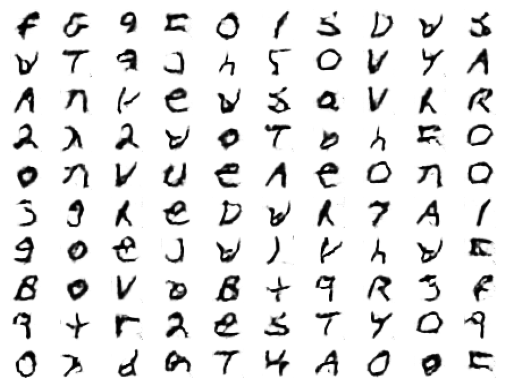

>Saved: generated_plot_11280.png and model_11280.h5
2/2 [==============================] - 1s 451ms/step
>11281, dr[0.712,1.023], df[0.714,0.048], g[0.874,0.058]
2/2 [==============================] - 1s 452ms/step
>11282, dr[0.649,1.216], df[0.743,0.023], g[0.908,0.021]
2/2 [==============================] - 1s 448ms/step
>11283, dr[0.658,0.893], df[0.571,0.027], g[0.874,0.028]


KeyboardInterrupt: 

In [137]:
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

## Generación de datos

Ahora que la red ACGAN ha sido entrenada podemos generar una letra o número de la clase que queramos. Simplemente cargamos el modelo que nos interesa que haya ido mejor y como toda red, le damos a predecir. En este caso vamos a probar con el número '7' y la letra 'a'.

Debido a como el entrenamiento se ha medido de forma heurística (eso es, vemos a ojo como va) es posible que el espacio latente no haya quedado completamente definido por las clases, pero la mayoría de las veces debería de sacar un valor correcto.

Además, por como las letras a mano de la base de datos original en este caso tienen pocas variaciones de por sí, es muy difícil detectar un colapso modal... y debido a las clases siendo patrones relativamente específicos, pues importa bastante poco, de hecho el uso de clases es una forma de reducir el colapso modal en las conditional GAN, de tal forma que se divide el espacio latente de forma adecuada.

NOTA: Saldrá un warning de que tensorflow no encontró la configuración de entrenamiento, y que por lo tanto eso no fue compilado. No nos preocupemos, pues solo nos importa si quisiéramos reentrenar la red.

C:\Users\andro\AppData\Roaming\Python\Python39\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4/4 [==============================] - 3s 565ms/step


C:\Users\andro\AppData\Local\Temp\ipykernel_31312\3111816413.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)


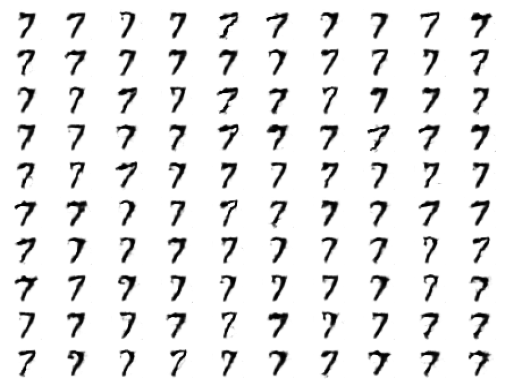

In [140]:
# este método genera espacio latente, pero en vez de para el entrenamiento donde es aleatorio, aquí es una clase específica
def generate_latent_points2(latent_dim, n_samples, n_class):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]
 
# muestra la imagen de predicciones
def mostrar_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()
 
# cargo el modelo
model = load_model('model_11280.h5')

# configuración del modelo
latent_dim = 100
n_examples = 100 # para pintarlo debe ser un cuadrado
n_class = 7 # El número 7
# genero la imagen, y la pinto
latent_points, labels = generate_latent_points2(latent_dim, n_examples, n_class)
X  = model.predict([latent_points, labels])
# reajusto la escala de imagen a un formato entendible para el pintado, es decir,invierto la transformación de escala de [-1,1] a [0,1]
X = (X + 1) / 2.0
mostrar_plot(X, n_examples)

4/4 [==============================] - 2s 559ms/step


C:\Users\andro\AppData\Local\Temp\ipykernel_31312\3111816413.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)


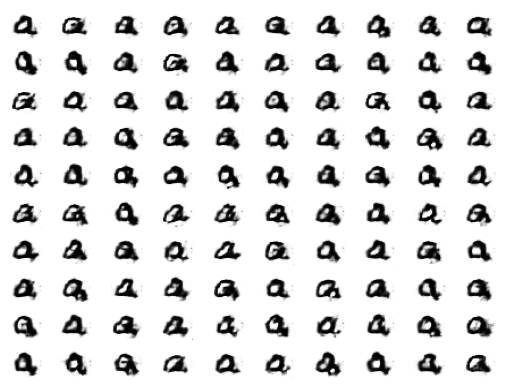

In [149]:
n_class = LosCaracteres.ela.value # La a
# generate images
latent_points, labels = generate_latent_points2(latent_dim, n_examples, n_class)
# generate images
X2  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X2 = (X2 + 1) / 2.0
# plot the result
save_plot(X2, n_examples)

Ahora viene lo guay, vamos a escribir "Hola1Mundo" con nuestras predicciones.

Nótese que debe tenerse cuidado en el caso de una enum si se replican números, ya que el primero sobreescribirá al segundo, y por lo tanto el segundo no aparecerá (por ejemplo en nuestro Enum de caracteres, "elC" y "elc" tienen el mismo número, y por lo tanto, solo "elC" existe). Por lo tanto nuestra función tiene en cuenta eso para encontrar el carácter adecuado, de tal forma que si no lo encuentra a la priemra pasa el carácter a mayúsculas.

De paso también vamos a ajustar el programa para quitarnos el problema del MatplotlibDeprecationWarning de encima.

1/1 [==============================] - 0s 53ms/step


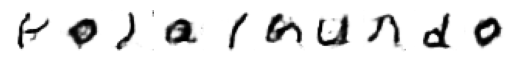

In [161]:
# TO-DO AHORA HACEMOS Hola mundo con las letras obtenidas,

def una_letra(num_class, mimodelo, n_ejemplos=100, milatent_dim=100, verboso=0):
    #n_ejemplos no debería ser 1 y ya?
    # TO-DO ajustar para que sea solo 1
    latent_points, labels = generate_latent_points2(milatent_dim, n_ejemplos, num_class)
    X  = mimodelo.predict([latent_points, labels], verbose=verboso)
    X = (X + 1) / 2.0
    # mostrar imágenes por pantalla
    return X[0, :, :, 0] # el primer 0 es una elección arbitraria, podría ser cualquiera de entre los ejemplos calculados


def imprimir_texto_a_mano(cadena, mimodelo, letrasPorLinea = 10, verboso=1):
    numeroDeLineas = len(cadena)/letrasPorLinea +1
    
    for i in range(len(cadena)):
        elChar = cadena[i]
        if elChar == " ":
            print(" ", end="")
        elif elChar == "\n":
            print(" ")
        else:
            enc = -1
            for j in LosCaracteres:
                if (j.name == ("el"+elChar)):
                    enc = j.value
                    #print(j.name)
            if enc == -1:
                elChar = elChar.upper()
                for j in LosCaracteres:
                    if (j.name == ("el"+elChar)):
                        enc = j.value
                        #print(j.name)
            if enc == -1:
                print (" ") # si es un caracter desconocido, saltamos de línea
            
            else:
                #print(enc)
                plt.subplot(int(numeroDeLineas), int(letrasPorLinea), int(1 + i))
                plt.axis('off')
                plt.imshow(una_letra(enc, mimodelo, 1, 100, verboso), cmap='gray_r')
                
    plt.show
    
imprimir_texto_a_mano("Hola1Mundo", model, letrasPorLinea = 10)

Mira, incluso tiene una letra de mejor calidad que la del estudiante de universidad de medicina medio.

Ahora escribiremos las conclusiones con nuestra red ACGAN. Vamos a reajustar el espacio del pyplot para que nos deje escribir bien, que si no el programa parece que te intenta escribir en al´gun lenguaje de arriba-abajo con letra minúscula.

In [164]:
plt.rcParams.update({'figure.figsize': (30, 50),'figure.dpi': 128})

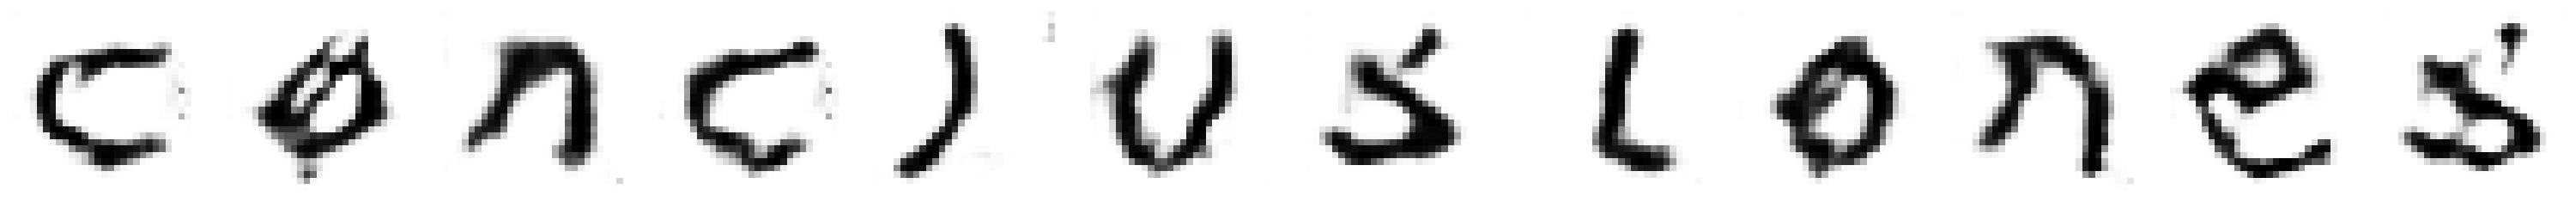

In [166]:
imprimir_texto_a_mano("Conclusiones\n", model, letrasPorLinea = 12, verboso=0)

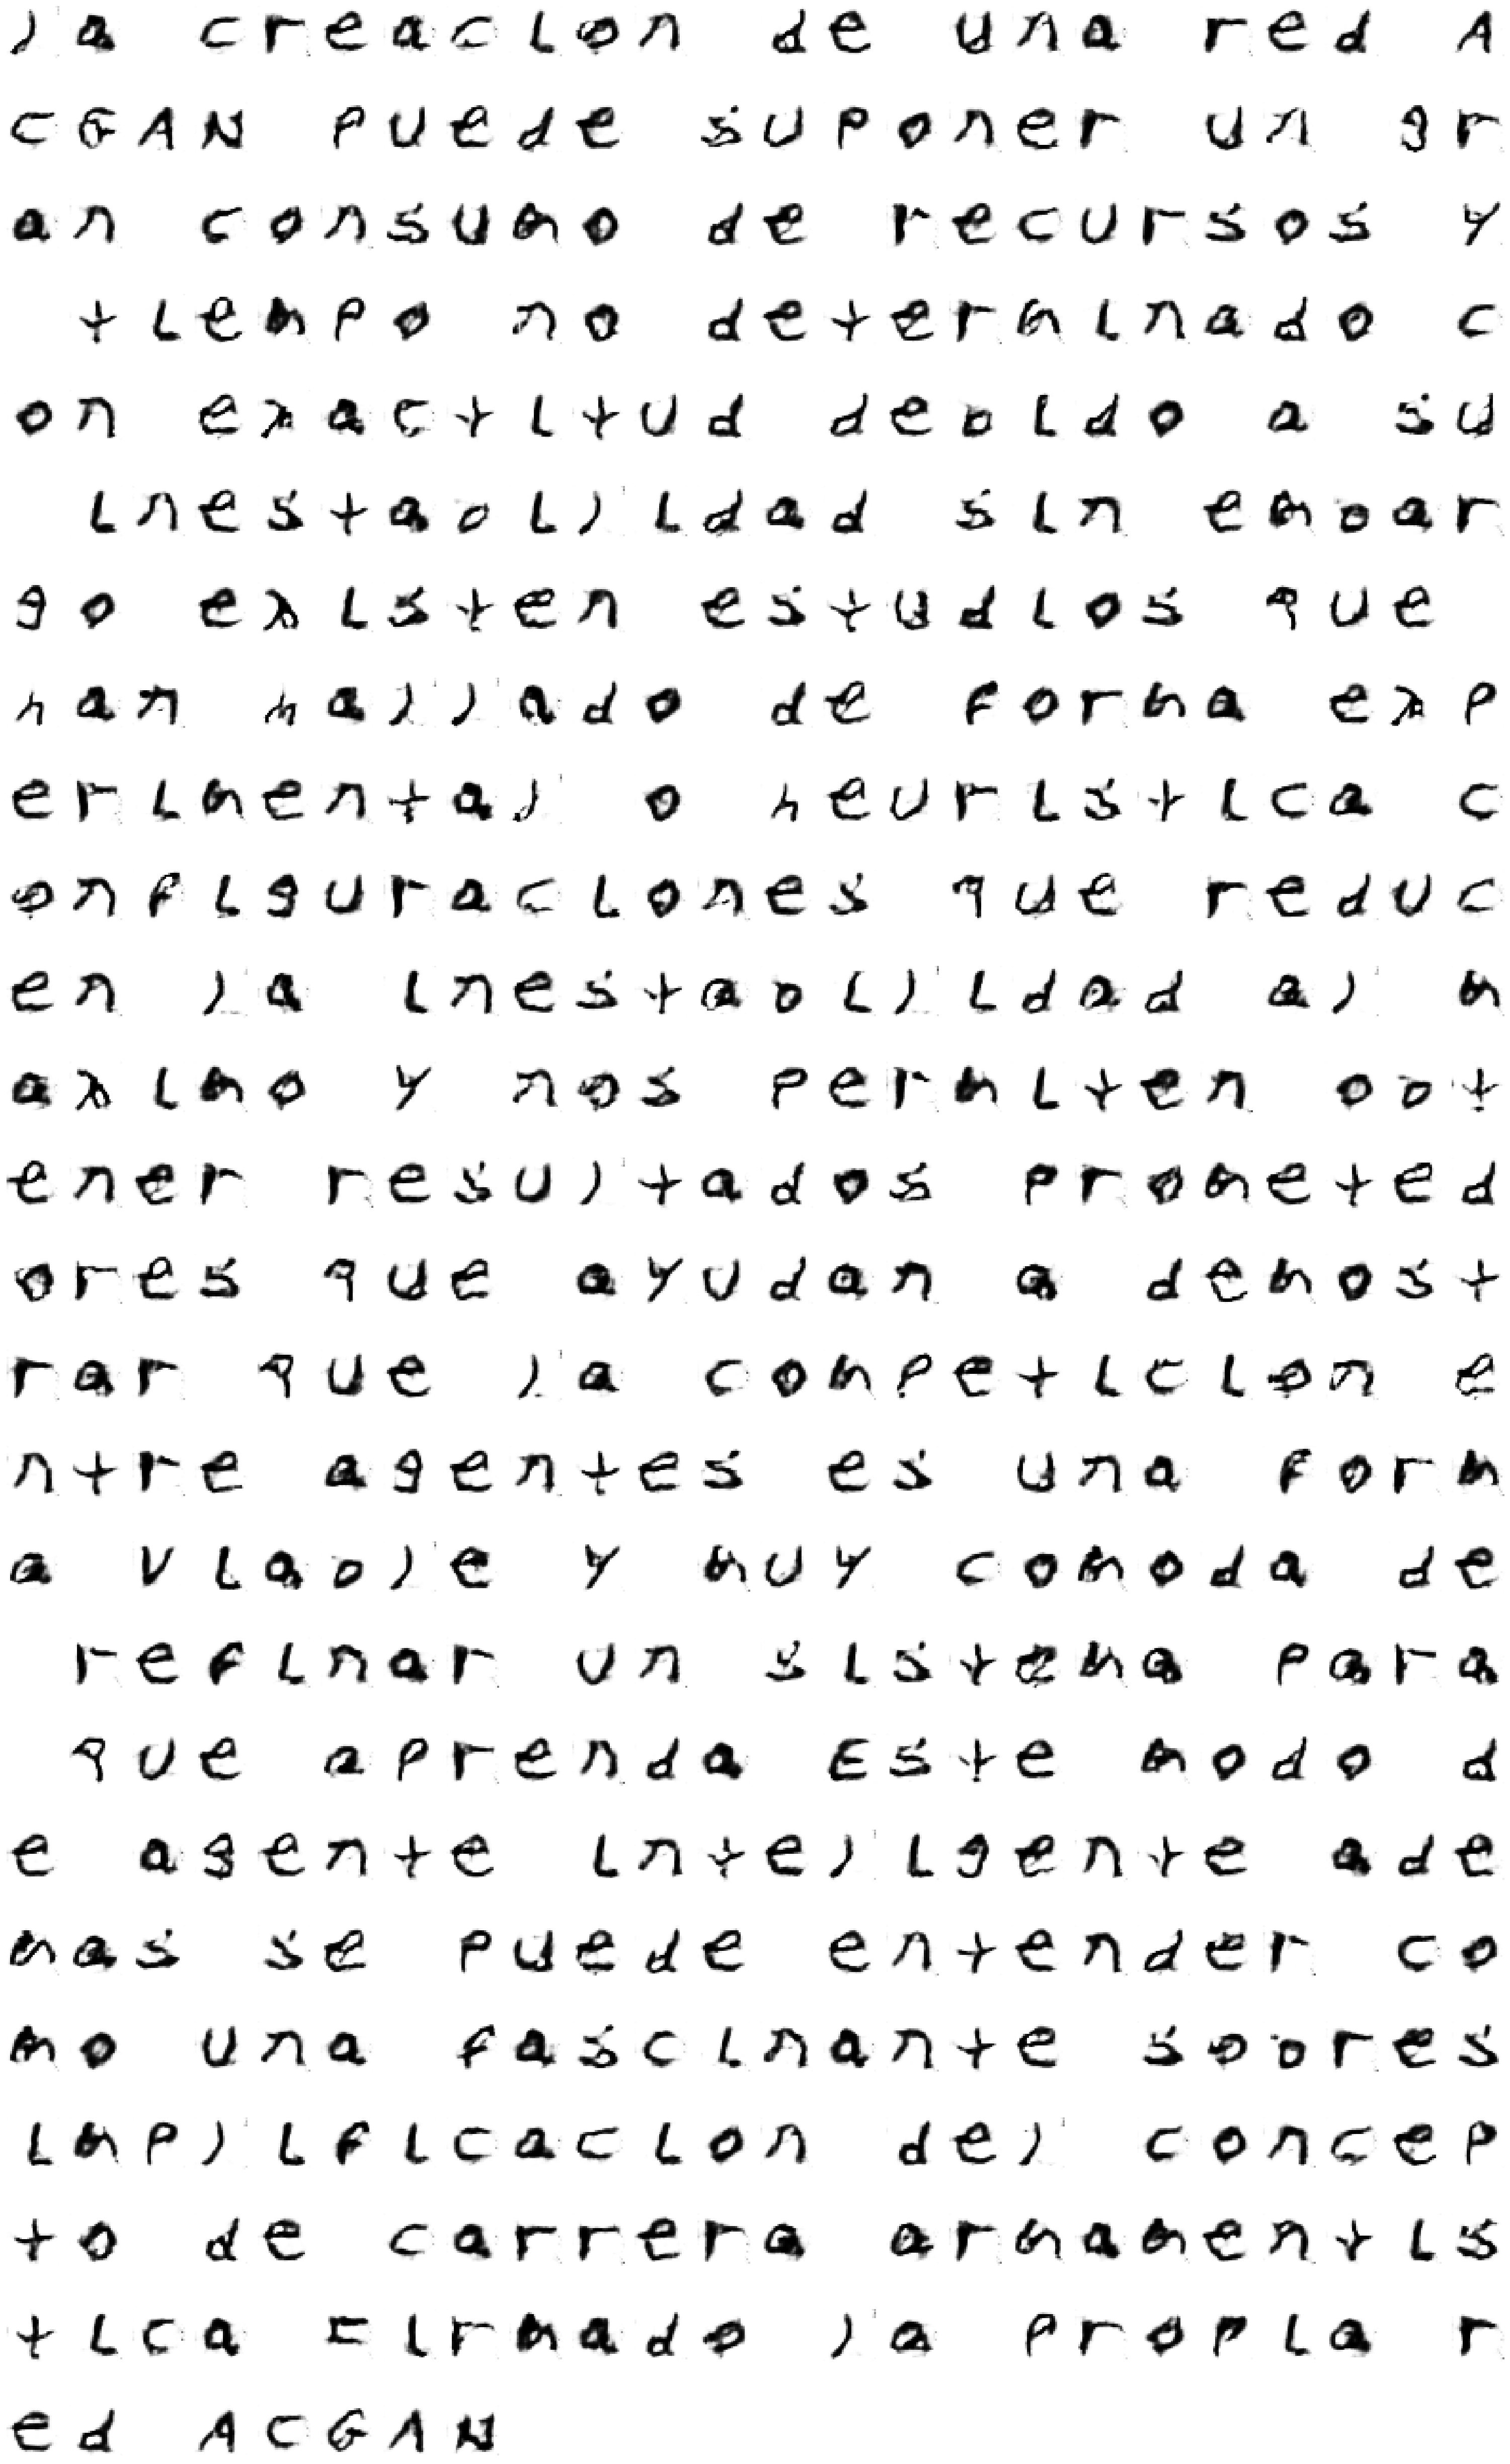

In [167]:
imprimir_texto_a_mano("La creacion de una red ACGAN puede suponer un gran consumo de recursos y tiempo no determinado con exactitud debido a su inestabilidad\nSin embargo existen estudios que han hallado de forma experimental o heuristica configuraciones que reducen la inestabilidad al maximo y nos permiten obtener resultados prometedores que ayudan a demostrar que la competicion entre agentes es una forma viable y muy comoda de refinar un sistema para que aprenda\nEste modo de agente inteligente ademas se puede entender como una fascinante sobresimplificacion del concepto de carrera armamentistica\nFirmado\nLa propia red ACGAN", model, letrasPorLinea = 24, verboso=0)

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>